# Model Diagnosis and Tuning


### Determining Optimal Probability Cutoff

Predicted proabability is a number between 0 and 1. Traditionally >.5 is the cutoff point used for converting predicted proabability to 1 (positive) otherwise 0 (negative). This logic works well when your training data set has equal example of positive and negative cases, however this is not the case in real world scenarios.

### Solution:

The solution is to find the optimal cut off point, that is the point where true positive rate is high and the false positive rate is low. Anything above this threold can be labeled as 1 else 0. Let's understand this better with an example.

### Dataset

We'll be using the dataset from the UCI repository, dataset "Pima Indian diabetes": 2 classes, 8 attributes, 768 instances, 500 (65.1%) negative (class1), and 268 (34.9%) positive tests for diabetes. class2. All patients were females at least 21 years old of Pima Indian heritage.

Attributes used:

    1. Number of times pregnant
    2. Plasma glucose concentration a 2 hours in an oral glucose tolerance test
    3. Diastolic blood pressure (mm Hg)
    4. Triceps skin fold thickness (mm)
    5. 2-Hour serum insulin (mu U/ml)
    6. Body mass index (weight in kg/(height in m)^2)
    7. Diabetes pedigree function
    8. Age (years)



In [3]:
import pandas as pd
import pylab as plt
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn import metrics

In [4]:
# read the data in
df = pd.read_csv("data/Diabetes.csv")
df.head()

# target variable % distribution
print (df['class'].value_counts(normalize=True))

X = df.iloc[:,:8]     # independent variables
y = df['class'] 

0    0.651042
1    0.348958
Name: class, dtype: float64


In [5]:
# evaluate the model by splitting into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)

# instantiate a logistic regression model, and fit 
model = LogisticRegression()
model = model.fit(X_train, y_train)

# predict class labels for the train set. The predict fuction converts probability values > .5 to 1 else 0
y_pred = model.predict(X_train)

# generate class probabilities 
# Notice that 2 elements will be returned in probs array, 
# 1st element is probability for negative class,
# 2nd element gives probability for positive class
probs = model.predict_proba(X_train)
y_pred_prob = probs[:, 1]

# generate evaluation metrics
print ("Accuracy: ", metrics.accuracy_score(y_train, y_pred))

Accuracy:  0.767225325885




The optimal cut off would be where tpr is high and fpr is low, and tpr - (1-fpr) is zero or near to zero


Area under the ROC curve : 0.833293


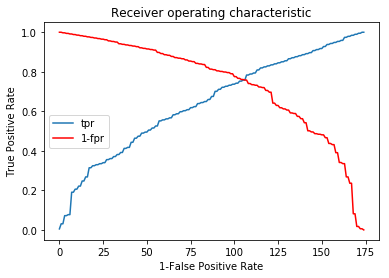

In [7]:
# extract false positive, true positive rate
fpr, tpr, thresholds = metrics.roc_curve(y_train, y_pred_prob)
roc_auc = metrics.auc(fpr, tpr)
print("Area under the ROC curve : %f" % roc_auc)

i = np.arange(len(tpr)) # index for df
roc = pd.DataFrame({'fpr' : pd.Series(fpr, index=i),'tpr' : pd.Series(tpr, index = i), 
                    '1-fpr' : pd.Series(1-fpr, index = i), 'tf' : pd.Series(tpr - (1-fpr), index = i), 
                    'thresholds' : pd.Series(thresholds, index = i)})
roc.iloc[(roc.tf-0).abs().argsort()[:1]]

# Plot tpr vs 1-fpr
fig, ax = plt.subplots()
plt.plot(roc['tpr'], label='tpr')
plt.plot(roc['1-fpr'], color = 'red', label='1-fpr')
plt.legend(loc='best')
plt.xlabel('1-False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.show()



To simplify finding optimal probability threshold and bring in re-usability, I have made a function to find the optimal probability cutoff point.


In [12]:
def Find_Optimal_Cutoff(target, predicted):
    """ Find the optimal probability cutoff point for a classification model related to event rate
    Parameters
    ----------
    target : Matrix with dependent or target data, where rows are observations

    predicted : Matrix with predicted data, where rows are observations

    Returns
    -------     
    list type, with optimal cutoff value

    """
    fpr, tpr, threshold = metrics.roc_curve(target, predicted)
    i = np.arange(len(tpr)) 
    roc = pd.DataFrame({'tf' : pd.Series(tpr-(1-fpr), index=i), 'threshold' : pd.Series(threshold, index=i)})
    roc_t = roc.iloc[(roc.tf-0).abs().argsort()[:1]]

    return list(roc_t['threshold'])

In [13]:
# Find optimal probability threshold
# Note: probs[:, 1] will have probability of being positive label
threshold = Find_Optimal_Cutoff(y_train, probs[:, 1])
print ("Optimal Probability Threshold: ", threshold)

# Applying the threshold to the prediction probability
y_pred_optimal = np.where(y_pred_prob >= threshold, 1, 0)

# Let's compare the accuracy of traditional/normal approach vs optimal cutoff
print ("\nNormal - Accuracy: ", metrics.accuracy_score(y_train, y_pred))
print ("Optimal Cutoff - Accuracy: ", metrics.accuracy_score(y_train, y_pred_optimal))
print ("\nNormal - Confusion Matrix: \n", metrics.confusion_matrix(y_train, y_pred))
print ("Optimal - Cutoff Confusion Matrix: \n", metrics.confusion_matrix(y_train, y_pred_optimal))

Optimal Probability Threshold:  [0.36102423741911216]

Normal - Accuracy:  0.767225325885
Optimal Cutoff - Accuracy:  0.75791433892

Normal - Confusion Matrix: 
 [[303  40]
 [ 85 109]]
Optimal - Cutoff Confusion Matrix: 
 [[260  83]
 [ 47 147]]


Notice that there is no significant difference in overall accuracy between normal vs. optimal cutoff method; both are 76%. However there is a 36% increase in the true positive rate in the optimal cutoff method; that is, you are now able to capture 36% more positive cases as positive; also the false positive (Type I error) has doubled, that is, the probability
of predicting an individual not having diabetes as positive has increases. <br>
### Which error is costly?
Well, there is no one answer for this questoin! It depends on the domain, problem that you are trying to address and the business requirement. In our case comparatively type II error might be more damaging than type I error.

![alt text][logo]

[logo]: https://github.com/sara-kassani/Python/blob/master/data/error.png?raw=true "K-means"


# Rare event or Unbalanced data set

Providing equal sample of positive and negative instances to the classification algorithm will result in optimal result. Dataset which are highly skewed towards one or more classes have proven to be a challenge. <br>

Resampling is a common practice of addressing this issue. Although there are many techniques within re-sampling, here we'll be learning the 3 most popular techniques.

- Random under-sampling - Reduce majority class to match minority class count
- Random over-sampling - Increase minority class by randomly picking samples within minority class till counts of both class match
- Synthetic Minority Over Sampling Technique (SMOTE) - Increase minority class by introducing synthetic examples through connecting all k (default = 5) minority class nearest negihbors using feature space similarity (Euclidean distance)

A number of techniques have been implemented in "imbalanced-learn" python package hosted at https://github.com/scikit-learn-contrib/imbalanced-learn. Follow the instructions in the link to install it, if not already installed.

![alt text][logo]

[logo]: https://github.com/sara-kassani/Python/blob/master/data/Sampling.png?raw=true "Imbalanced dataset handling techniques"
 - Imbalanced dataset handling techniques
 
Let’s create a sample imbalanced dataset using make_classification function of sklearn.

In [15]:
# Load libraries
import matplotlib.pyplot as plt
from sklearn.datasets import make_classification

from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import RandomOverSampler
from imblearn.over_sampling import SMOTE

In [16]:
# Generate the dataset with 2 features to keep it simple 
X, y = make_classification(n_samples=5000, n_features=2, n_informative=2, 
                           n_redundant=0, weights=[0.9, 0.1], random_state=2017) 

print ("Positive class: ", y.tolist().count(1))
print ("Negative class: ", y.tolist().count(0))

Positive class:  514
Negative class:  4486


### Applying the sampling techniques
Let’s apply the above described three sampling techniques to the dataset to balance the dataset and visualize for better understanding.

In [17]:
# Apply the random under-sampling
rus = RandomUnderSampler()
X_RUS, y_RUS = rus.fit_sample(X, y)

# Apply the random over-sampling
ros = RandomOverSampler()
X_ROS, y_ROS = ros.fit_sample(X, y)

# Apply regular SMOTE
sm = SMOTE(kind='regular')
X_SMOTE, y_SMOTE = sm.fit_sample(X, y)

### Plot the original vs re-sampled

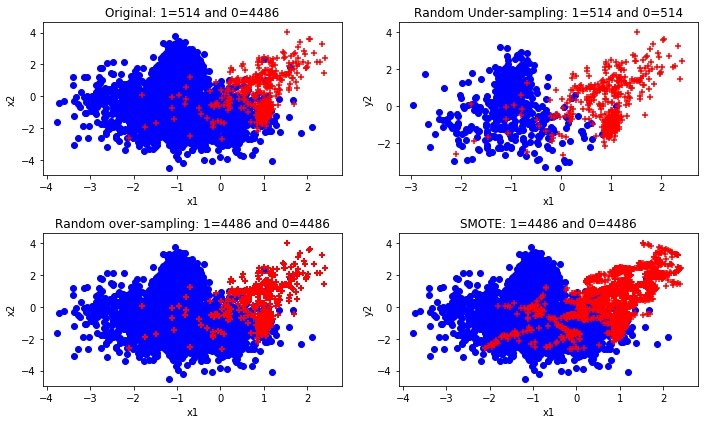

In [18]:
# Original vs resampled subplots
plt.figure(figsize=(10, 6))
plt.subplot(2,2,1)
plt.scatter(X[y==0,0], X[y==0,1], marker='o', color='blue')
plt.scatter(X[y==1,0], X[y==1,1], marker='+', color='red')
plt.xlabel('x1')
plt.ylabel('x2')
plt.title('Original: 1=%s and 0=%s' %(y.tolist().count(1), y.tolist().count(0)))

plt.subplot(2,2,2)
plt.scatter(X_RUS[y_RUS==0,0], X_RUS[y_RUS==0,1], marker='o', color='blue')
plt.scatter(X_RUS[y_RUS==1,0], X_RUS[y_RUS==1,1], marker='+', color='red')
plt.xlabel('x1')
plt.ylabel('y2')
plt.title('Random Under-sampling: 1=%s and 0=%s' %(y_RUS.tolist().count(1), y_RUS.tolist().count(0)))

plt.subplot(2,2,3)
plt.scatter(X_ROS[y_ROS==0,0], X_ROS[y_ROS==0,1], marker='o', color='blue')
plt.scatter(X_ROS[y_ROS==1,0], X_ROS[y_ROS==1,1], marker='+', color='red')
plt.xlabel('x1')
plt.ylabel('x2')
plt.title('Random over-sampling: 1=%s and 0=%s' %(y_ROS.tolist().count(1), y_ROS.tolist().count(0)))

plt.subplot(2,2,4)
plt.scatter(X_SMOTE[y_SMOTE==0,0], X_SMOTE[y_SMOTE==0,1], marker='o', color='blue')
plt.scatter(X_SMOTE[y_SMOTE==1,0], X_SMOTE[y_SMOTE==1,1], marker='+', color='red')
plt.xlabel('x1')
plt.ylabel('y2')
plt.title('SMOTE: 1=%s and 0=%s' %(y_SMOTE.tolist().count(1), y_SMOTE.tolist().count(0)))

plt.tight_layout()
plt.show()

### Known disadvantages:

- Random Under-Sampling rises opportunity for loss of information or concepts as we are reducing the majority class
- Random Over-Sampling & SMOTE can lead to overfitting issue due to multiple related instances

### Which re-sampling technique is the best?
Well, as always there is no one answer to this question! Let's try a quick classification model on 3 re-sampled data and compare the accuracy (we'll use AUC as this one of the best representation of model performance)

In [19]:
from sklearn import tree
from sklearn import metrics

# split data into train and test
from sklearn.cross_validation import train_test_split

X_RUS_train, X_RUS_test, y_RUS_train, y_RUS_test = train_test_split(X_RUS, y_RUS, test_size=0.3, random_state=2017)
X_ROS_train, X_ROS_test, y_ROS_train, y_ROS_test = train_test_split(X_ROS, y_ROS, test_size=0.3, random_state=2017)
X_SMOTE_train, X_SMOTE_test, y_SMOTE_train, y_SMOTE_test = train_test_split(X_SMOTE, y_SMOTE, test_size=0.3, random_state=2017)

# build a decision tree classifier
clf = tree.DecisionTreeClassifier(random_state=2017)
clf_rus = clf.fit(X_RUS_train, y_RUS_train)
clf_ros = clf.fit(X_ROS_train, y_ROS_train)
clf_smote = clf.fit(X_SMOTE_train, y_SMOTE_train)

# evaluate model performance
print ("\nRUS - Train AUC : ",metrics.roc_auc_score(y_RUS_train, clf.predict(X_RUS_train)))
print ("RUS - Test AUC : ",metrics.roc_auc_score(y_RUS_test, clf.predict(X_RUS_test)))
print ("ROS - Train AUC : ",metrics.roc_auc_score(y_ROS_train, clf.predict(X_ROS_train)))
print ("ROS - Test AUC : ",metrics.roc_auc_score(y_ROS_test, clf.predict(X_ROS_test)))
print ("\nSMOTE - Train AUC : ",metrics.roc_auc_score(y_SMOTE_train, clf.predict(X_SMOTE_train)))
print ("SMOTE - Test AUC : ",metrics.roc_auc_score(y_SMOTE_test, clf.predict(X_SMOTE_test)))


RUS - Train AUC :  0.985835979246
RUS - Test AUC :  0.987436868687
ROS - Train AUC :  0.988516746411
ROS - Test AUC :  0.959110024833

SMOTE - Train AUC :  1.0
SMOTE - Test AUC :  0.955409062583


### Conclusion

Here random over sampling is performing better on both train and test sets. As a best practice, in real world use cases it is recommended to look at other matrics (such as confusion matrix) and apply business context or domain knowledge to assess true performance of model.


# Bias-Variance Tradeoff

A fundamental problem with supervised learning is the bias-variance tradeoff. Ideally a model should have two key characteristics

1) sensitive enough to accurately capture the key patterns in the training dataset,

2) at the same time it should be generalized enough to work well on any unseen datasets.

Unfortunately, whilst trying to achieve the afore mentioned first point, there is ample chances of over-fitting to noisy or unrepresentative training data points leading to a failure of generalizing the model. On the other hand, trying to generalize model may result in failing to capture important regularities.

### Bias
If a model accuracy is low on training dataset as well as test dataset the model is said to be underfitting or model has high biase. This means the model is not fitting the training dataset points well in regression or decision boundary is not separating the classes well in classification, and two key reasons for bias is 1) not including the right features 2) not picking the correct order of polynomial degree for model fitting.

To solve underfitting issue or to reduced bias try including more meaningful features and try to increase the model complexity by trying higher order polynomial fittings.

### Variance
If a model is giving high accuracy on training dataset, however on test dataset the accuracy drops drastically then the model is said to be overfitting or model has high variance. The key reason for overfitting is using higher order polynomial degree (may not be required), which will fit decision boudary tool well to all data points including the noise of train dataset, instead of the underlying relationship. This will lead to a high accuracy (actual vs predicted) in train dataset and when applied to the test dataset the prediction error will be high.

#### To solve over-fitting issue:

- try to reduce the number of features i.e., keep only the meanigful features or try regularization methods which will keep all the features however reduce the magnitude of the feature parameter
- Dimension reduction can eliminate noisy features, in turn reducing the model variance
- Brining more data points to make training dataset large will also reduce variance
- Choosing right model paramters can help to reduce the bias and variance, for example
       - Using right regularization parameters can decrease variance in regression based models
       - For a decision tree reducing the depth of the decision tree will reduce the variance

![alt text][logo]

[logo]: https://github.com/sara-kassani/Python/blob/master/data/bias.png?raw=true "Bias - Variance"


## K-Fold Cross Validation

K-folds cross validation splits the training dataset into k folds without replacement i.e., any given data point will only be part of one of the subset, where k-1 folds are used for the model training and one fold is used for testing. The procedure is repeated k times so that we obtain k models and performance estimates. <br>

We then calcuate the averge performance of the models based on the individual folds to obtain a performance estimate that is less sensitive to the subpartitioning of the training data compared to the holdout or single fold method.<br>

An extended cross-validation is the Stratified K-fold cross validation, where the class proportions are preserved in each fold leading to a better bias and variance estimates.
![alt text][logo]

[logo]: https://github.com/sara-kassani/Python/blob/master/data/k-fold.png?raw=true "Bias - Variance"
### Hold-out or single fold model

In [21]:
import pandas as pd
import pylab as plt
import numpy as np

from sklearn.preprocessing import StandardScaler
from sklearn.cross_validation import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
from sklearn import cross_validation

# read the data in
df = pd.read_csv("data/Diabetes.csv")

X = df.iloc[:,:8].values     # independent variables
y = df['class'].values     # dependent variables

# Normalize Data
sc = StandardScaler()
sc.fit(X)
X = sc.transform(X)

# evaluate the model by splitting into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=2017)

# instantiate a logistic regression model, and fit 
clf = LogisticRegression(random_state=2017)
clf = clf.fit(X_train, y_train)

# evaluate model
print ("Train Score: ", clf.score(X_train, y_train))
print ("Test Score: ", clf.score(X_test, y_test))

Train Score:  0.772811918063
Test Score:  0.792207792208


### Now let's try 5-fold cross-validation, to see if the accuracy holds up more rigorously

In [22]:
from sklearn.cross_validation import cross_val_score

# evaluate the model using 10-fold cross-validation
train_scores = cross_val_score(clf, X_train, y_train, scoring='accuracy', cv=5)
test_scores = cross_val_score(clf, X_test, y_test, scoring='accuracy', cv=5)
print ("Train Fold AUC Scores: ", train_scores)
print ("Train CV AUC Score: ", train_scores.mean())
print ("\nTest Fold AUC Scores: ", test_scores)
print ("Test CV AUC Score: ", test_scores.mean())

Train Fold AUC Scores:  [ 0.80555556  0.73148148  0.81308411  0.76635514  0.71028037]
Train CV AUC Score:  0.765351332641

Test Fold AUC Scores:  [ 0.80851064  0.78723404  0.78723404  0.77777778  0.8       ]
Test CV AUC Score:  0.792151300236


### Let's try Stratified 5-fold cross-validation
An extended cross-validation is the Stratified K-fold cross-validation, where the class proportions are preserved in each fold, leading to better bias and variance estimates.

In [23]:
kfold = cross_validation.StratifiedKFold(y=y_train, n_folds=5, random_state=2017)

train_scores = []
test_scores = []
for k, (train, test) in enumerate(kfold):
    clf.fit(X_train[train], y_train[train])
    train_score = clf.score(X_train[train], y_train[train])
    train_scores.append(train_score)
    # score for test set
    test_score = clf.score(X_train[test], y_train[test])
    test_scores.append(test_score)

    print('Fold: %s, Class dist.: %s, Train Acc: %.3f, Test Acc: %.3f' % (k+1, np.bincount(y_train[train]), train_score, test_score))
    
print('\nTrain CV accuracy: %.3f' % (np.mean(train_scores)))
print('Test CV accuracy: %.3f' % (np.mean(test_scores)))

Fold: 1, Class dist.: [277 152], Train Acc: 0.758, Test Acc: 0.806
Fold: 2, Class dist.: [277 152], Train Acc: 0.779, Test Acc: 0.731
Fold: 3, Class dist.: [278 152], Train Acc: 0.767, Test Acc: 0.813
Fold: 4, Class dist.: [278 152], Train Acc: 0.781, Test Acc: 0.766
Fold: 5, Class dist.: [278 152], Train Acc: 0.781, Test Acc: 0.710

Train CV accuracy: 0.773
Test CV accuracy: 0.765


## Ensemble Methods
Ensemble methods enable combining multiple model scores into a single score to create a robust generalized model.<br>
At a high level there are two types of ensemble methods. <br>
1) Combine multiple models of similar type
        - Bagging (Bootstrap aggregation)
         -Boosting

2)	Combine multiple models of various types
        - Vote Classification
        - Blending or Stacking

# Bagging (Bootstrap aggregation)

Bootstrap aggregation (also known as bagging) was proposed by Leo Breiman in 1994, which is model aggregation technique to reduce model variance. The training data is splited into multiple samples with replacement called as boostrap samples. Bootstrap sample size will be same as original sample size, with 3/4th of the original values and replacement result in repetition of values.
![alt text][logo]

[logo]: https://github.com/sara-kassani/Python/blob/master/data/Bootstraping.jpg?raw=true "K-means"

![alt text][logo]

[logo]: https://github.com/sara-kassani/Python/blob/master/data/Bagging.png?raw=true "Bagging.png"

In [26]:
import pandas as pd
import numpy as np

from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.cross_validation import train_test_split
from sklearn import cross_validation
from sklearn import metrics

from matplotlib.colors import ListedColormap
import matplotlib.pyplot as plt
%matplotlib inline

# Bagged Decision Trees for Classification
from sklearn.ensemble import BaggingClassifier
from sklearn.tree import DecisionTreeClassifier

# read the data in
df = pd.read_csv("data/Diabetes.csv")

X = df.iloc[:,:8].values     # independent variables
y = df['class'].values     # dependent variables

#Normalize
X = StandardScaler().fit_transform(X)

# evaluate the model by splitting into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=2017)

kfold = cross_validation.StratifiedKFold(y=y_train, n_folds=5, random_state=2017)
num_trees = 100

# Dection Tree with 5 fold cross validation
clf_DT = DecisionTreeClassifier(random_state=2017).fit(X_train,y_train)
results = cross_validation.cross_val_score(clf_DT, X_train,y_train, cv=kfold)
print ("Decision Tree (stand alone) - Train : ", results.mean())
print ("Decision Tree (stand alone) - Test : ", metrics.accuracy_score(clf_DT.predict(X_test), y_test))

# Using Bagging Lets build 100 decision tree models and average/majority vote prediction
clf_DT_Bag = BaggingClassifier(base_estimator=clf_DT, n_estimators=num_trees, random_state=2017).fit(X_train,y_train)
results = cross_validation.cross_val_score(clf_DT_Bag, X_train, y_train, cv=kfold)
print ("\nDecision Tree (Bagging) - Train : ", results.mean())
print ("Decision Tree (Bagging) - Test : ", metrics.accuracy_score(clf_DT_Bag.predict(X_test), y_test))

Decision Tree (stand alone) - Train :  0.701983077737
Decision Tree (stand alone) - Test :  0.753246753247

Decision Tree (Bagging) - Train :  0.747461660497
Decision Tree (Bagging) - Test :  0.818181818182


### Feature Importance

Decision tree model has an attribute to show important features which is based on the gini or entropy information gain.


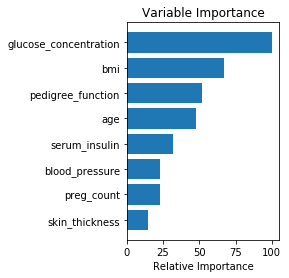

In [27]:
feature_importance = clf_DT.feature_importances_
# make importances relative to max importance
feature_importance = 100.0 * (feature_importance / feature_importance.max())
sorted_idx = np.argsort(feature_importance)
pos = np.arange(sorted_idx.shape[0]) + .5
plt.subplot(1, 2, 2)
plt.barh(pos, feature_importance[sorted_idx], align='center')
plt.yticks(pos, df.columns[sorted_idx])
plt.xlabel('Relative Importance')
plt.title('Variable Importance')
plt.show()


# Random Forest

A subset of observations and a subset of vairables are randomly picked to build multiple independent tree based models. The trees are more un-correlated as only a subset of variables are used during the split of the tree, rather than greedily choosing the best split point in the construction of the tree.


In [28]:
from sklearn.ensemble import RandomForestClassifier
num_trees = 100

X = df.iloc[:,:8].values     # independent variables
y = df['class'].values     # dependent variables

#Normalize
X = StandardScaler().fit_transform(X)

# evaluate the model by splitting into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=2017)

kfold = cross_validation.StratifiedKFold(y=y_train, n_folds=5, random_state=2017)

clf_RF = RandomForestClassifier(n_estimators=num_trees).fit(X_train, y_train)
results = cross_validation.cross_val_score(clf_RF, X_train, y_train, cv=kfold)

print ("\nRandom Forest - Train : ", results.mean())
print ("Random Forest - Test : ", metrics.accuracy_score(clf_RF.predict(X_test), y_test))



Random Forest - Train :  0.744235854045
Random Forest - Test :  0.811688311688


# Extremely Randomized Trees

This algorithm is an effort to introduce more randomness to the bagging process. Tree splits are chosen completely at random from the range of values in the sample at each split which allows to reduce the variance of the model further, however at the cost of slight increase in bias.


In [29]:
from sklearn.ensemble import ExtraTreesClassifier

num_trees = 100

X = df.iloc[:,:8].values     # independent variables
y = df['class'].values     # dependent variables

#Normalize
X = StandardScaler().fit_transform(X)

# evaluate the model by splitting into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=2017)

kfold = cross_validation.StratifiedKFold(y=y_train, n_folds=5, random_state=2017)

clf_ET = ExtraTreesClassifier(n_estimators=num_trees).fit(X_train, y_train)
results = cross_validation.cross_val_score(clf_ET, X_train, y_train, cv=kfold)

print ("\nExtraTree - Train : ", results.mean())
print ("ExtraTree - Test : ", metrics.accuracy_score(clf_ET.predict(X_test), y_test))


ExtraTree - Train :  0.74751454257
ExtraTree - Test :  0.792207792208



# How does the decision boudary look?

Let's perform PCA and consider only two component for easy plotting. The model building code would remain the same as above except that after normalization
and before splitting the data to train and test, we will need to add the line below.


In [44]:
# PCA
X = PCA(n_components=2).fit_transform(X)

# evaluate the model by splitting into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=2017)

num_folds = 5
seed = 2017

kfold = cross_validation.StratifiedKFold(y=y_train, n_folds=num_folds, random_state=seed)
num_trees = 100

# Dection Tree with 5 fold cross validation
clf_DT = DecisionTreeClassifier(random_state=seed).fit(X_train,y_train)
results = cross_validation.cross_val_score(clf_DT, X_train,y_train, cv=kfold)
print ("Decision Tree (stand alone) - Train : ", results.mean())
print ("Decision Tree (stand alone) - Test : ", metrics.accuracy_score(clf_DT.predict(X_test), y_test))

# Using Bagging Lets build 100 decision tree models and average/majority vote prediction
clf_DT_Bag = BaggingClassifier(base_estimator=clf_DT, n_estimators=num_trees, random_state=seed).fit(X_train,y_train)
results = cross_validation.cross_val_score(clf_DT_Bag, X_train, y_train, cv=kfold)
print ("\nDecision Tree (Bagging) - Train : ", results.mean())
print ("Decision Tree (Bagging) - Test : ", metrics.accuracy_score(clf_DT_Bag.predict(X_test), y_test))

clf_RF = RandomForestClassifier(n_estimators=num_trees).fit(X_train, y_train)
results = cross_validation.cross_val_score(clf_RF, X_train, y_train, cv=kfold)

print ("\nRandom Forest - Train : ", results.mean())
print ("Random Forest  - Test : ", metrics.accuracy_score(clf_RF.predict(X_test), y_test))

clf_ET = ExtraTreesClassifier(n_estimators=num_trees).fit(X_train, y_train)
results = cross_validation.cross_val_score(clf_ET, X_train, y_train, cv=kfold)

print ("\nExtraTree - Train : ", results.mean())
print ("ExtraTree - Test : ", metrics.accuracy_score(clf_ET.predict(X_test), y_test))

Decision Tree (stand alone) - Train :  0.628476996298
Decision Tree (stand alone) - Test :  0.642857142857

Decision Tree (Bagging) - Train :  0.656028556319
Decision Tree (Bagging) - Test :  0.655844155844

Random Forest - Train :  0.647990481227
Random Forest  - Test :  0.675324675325

ExtraTree - Train :  0.652802749868
ExtraTree - Test :  0.655844155844


# How Does the Decision Boundary Look?
Let’s perform PCA and consider only the first two principal components for easy plotting. The model building code would remain the same as above except that after normalization and before splitting the data to train and test, we will need to add the line below.

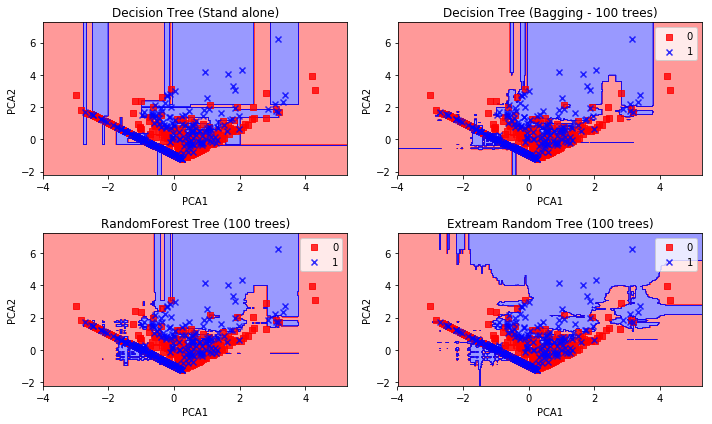

In [45]:
def plot_decision_regions(X, y, classifier):
    
    h = .02  # step size in the mesh
    # setup marker generator and color map
    markers = ('s', 'x', 'o', '^', 'v')
    colors = ('red', 'blue', 'lightgreen', 'gray', 'cyan')
    cmap = ListedColormap(colors[:len(np.unique(y))])

    # plot the decision surface
    x1_min, x1_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    x2_min, x2_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx1, xx2 = np.meshgrid(np.arange(x1_min, x1_max, h),
                           np.arange(x2_min, x2_max, h))
    Z = classifier.predict(np.array([xx1.ravel(), xx2.ravel()]).T)
    Z = Z.reshape(xx1.shape)
    plt.contourf(xx1, xx2, Z, alpha=0.4, cmap=cmap)
    plt.xlim(xx1.min(), xx1.max())
    plt.ylim(xx2.min(), xx2.max())

    for idx, cl in enumerate(np.unique(y)):
        plt.scatter(x=X[y == cl, 0], y=X[y == cl, 1],
                    alpha=0.8, c=cmap(idx),
                    marker=markers[idx], label=cl)

# Plot the decision boundary
plt.figure(figsize=(10,6))
plt.subplot(221)
plot_decision_regions(X, y, clf_DT)
plt.title('Decision Tree (Stand alone)')
plt.xlabel('PCA1')
plt.ylabel('PCA2')

plt.subplot(222)
plot_decision_regions(X, y, clf_DT_Bag)
plt.title('Decision Tree (Bagging - 100 trees)')
plt.xlabel('PCA1')
plt.ylabel('PCA2')
plt.legend(loc='best')

plt.subplot(223)
plot_decision_regions(X, y, clf_RF)
plt.title('RandomForest Tree (100 trees)')
plt.xlabel('PCA1')
plt.ylabel('PCA2')
plt.legend(loc='best')

plt.subplot(224)
plot_decision_regions(X, y, clf_ET)
plt.title('Extream Random Tree (100 trees)')
plt.xlabel('PCA1')
plt.ylabel('PCA2')
plt.legend(loc='best')
plt.tight_layout()

# Bagging – Essential Tuning Parameters
- n_estimators: This is the number of trees, the larger the better. Note that beyond a certain point the results will not improve significantly.
- max_features: This is the random subset of features to be used for splitting node, the lower the better to reduce variance (but increases bias). Ideally, for a regression problem it should be equal to n_features (total number of features) and for classification square root of n_features.
- n_ jobs: Number of cores to be used for parallel construction of trees. If set to -1, all available cores in the system are used, or you can specify the number.

# Boosting
Freud and Schapire in 1995 introduced the concept of boosting with the well-known AdaBoost algorithm (adaptive boosting). The core concept of boosting is that rather than an independent individual hypothesis, combining hypotheses in a sequential order increases the accuracy. Essentially, boosting algorithms convert the weak learners into strong learners. Boosting algorithms are well designed to address the bias problems. 
<br> At a high level the AdaBoosting process can be divided into three steps.
![alt text][Boosting1]

[Boosting1]: https://github.com/sara-kassani/Python/blob/master/data/Boosting1.JPG?raw=true "Boosting1"
![alt text][Boosting2]

[Boosting2]: https://github.com/sara-kassani/Python/blob/master/data/Boosting2.JPG?raw=true "Boosting2"

![alt text][logo]

[logo]: https://github.com/sara-kassani/Python/blob/master/data/Boosting.png?raw=true "Boosting"

![alt text][Adaboost1]

[Adaboost1]: https://github.com/sara-kassani/Python/blob/master/data/Adaboost1.JPG?raw=true "Adaboost1"

![alt text][Adaboost2]

[Adaboost2]: https://github.com/sara-kassani/Python/blob/master/data/Adaboost2.JPG?raw=true "Adaboost2"

![alt text][Adaboost3]

[Adaboost3]: https://github.com/sara-kassani/Python/blob/master/data/Adaboost3.JPG?raw=true "Adaboost3"

# AdaBoosting
Stand-alone decision tree vs. adaboost

In [31]:
import pandas as pd
import numpy as np

from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.cross_validation import train_test_split
from sklearn import cross_validation
from sklearn import metrics

from matplotlib.colors import ListedColormap
import matplotlib.pyplot as plt
%matplotlib inline

# Bagged Decision Trees for Classification
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier

# read the data in
df = pd.read_csv("data/Diabetes.csv")

# Let's use some week features to build the tree
X = df[['age','serum_insulin']] # independent variables
y = df['class'].values     # dependent variables

#Normalize
X = StandardScaler().fit_transform(X)

# evaluate the model by splitting into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=2017)

kfold = cross_validation.StratifiedKFold(y=y_train, n_folds=5, random_state=2017)
num_trees = 100

# Dection Tree with 5 fold cross validation
# lets restrict max_depth to 1 to have more impure leaves
clf_DT = DecisionTreeClassifier(max_depth=1, random_state=2017).fit(X_train,y_train)
results = cross_validation.cross_val_score(clf_DT, X_train,y_train, cv=kfold)
print ("Decision Tree (stand alone) - CV Train : %.2f" % results.mean())
print ("Decision Tree (stand alone) - Test : %.2f" % metrics.accuracy_score(clf_DT.predict(X_train), y_train))
print ("Decision Tree (stand alone) - Test : %.2f" % metrics.accuracy_score(clf_DT.predict(X_test), y_test))

# Using Adaptive Boosting of 100 iteration
clf_DT_Boost = AdaBoostClassifier(base_estimator=clf_DT, n_estimators=num_trees, learning_rate=0.1, random_state=2017).fit(X_train,y_train)
results = cross_validation.cross_val_score(clf_DT_Boost, X_train, y_train, cv=kfold)
print ("\nDecision Tree (AdaBoosting) - CV Train : %.2f" % results.mean())
print ("Decision Tree (AdaBoosting) - Train : %.2f" % metrics.accuracy_score(clf_DT_Boost.predict(X_train), y_train))
print ("Decision Tree (AdaBoosting) - Test : %.2f" % metrics.accuracy_score(clf_DT_Boost.predict(X_test), y_test))

Decision Tree (stand alone) - CV Train : 0.64
Decision Tree (stand alone) - Test : 0.66
Decision Tree (stand alone) - Test : 0.65

Decision Tree (AdaBoosting) - CV Train : 0.69
Decision Tree (AdaBoosting) - Train : 0.72
Decision Tree (AdaBoosting) - Test : 0.71


Notice that in this case AdaBoost algorithm has given an average rise of 9% in accuracy score between train / test dataset compared to the stanalone decision tree model.

# Gradient Boosting

Due to the stage wise addictivity, the loss function can be represented in a form suitable for optimization. This gave birth to a class of generalized boosting algorithms known as generalized boosting algorithm (GBM). Gradient boosting is an example implementation of GBM and it can work with different loss functions such as regression, classification, risk modelling etc. As the name suggested it is a boosting algorithm which identifies shortcomings of a weak learner by gradients (AdaBoost uses high-weight data points), hence the name Gradient Boosting.
![alt text][logo]

[logo]: https://github.com/sara-kassani/Python/blob/master/data/Gboost.JPG?raw=true "Gradient Boosting"

In [32]:
from sklearn.ensemble import GradientBoostingClassifier

# Using Gradient Boosting of 100 iterations
clf_GBT = GradientBoostingClassifier(n_estimators=num_trees, learning_rate=0.1, random_state=2017).fit(X_train, y_train)
results = cross_validation.cross_val_score(clf_GBT, X_train, y_train, cv=kfold)

print ("\nGradient Boosting - CV Train : %.2f" % results.mean())
print ("Gradient Boosting - Train : %.2f" % metrics.accuracy_score(clf_GBT.predict(X_train), y_train))
print ("Gradient Boosting - Test : %.2f" % metrics.accuracy_score(clf_GBT.predict(X_test), y_test))


Gradient Boosting - CV Train : 0.70
Gradient Boosting - Train : 0.81
Gradient Boosting - Test : 0.66


Let’s look at the digit classification to illustrate how the model performance improves with each iteration.


Gradient Boosting - Train : 0.75
Gradient Boosting - Test : 0.73
Predicted letter:  ['T']


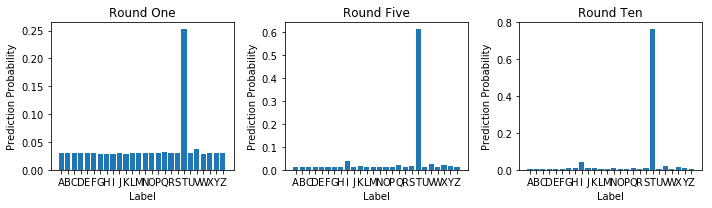

In [39]:
df= pd.read_csv('data/digit.csv')

X = df.iloc[:,1:17].values
y = df['lettr'].values   

# evaluate the model by splitting into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=2017)

kfold = cross_validation.StratifiedKFold(y=y_train, n_folds=5, random_state=2017)
num_trees = 10

clf_GBT = GradientBoostingClassifier(n_estimators=num_trees, learning_rate=0.1, random_state=2017).fit(X_train, y_train)
results = cross_validation.cross_val_score(clf_GBT, X_train, y_train, cv=kfold)

print ("\nGradient Boosting - Train : %.2f" % metrics.accuracy_score(clf_GBT.predict(X_train), y_train))
print ("Gradient Boosting - Test : %.2f" % metrics.accuracy_score(clf_GBT.predict(X_test), y_test))

# Let's predict for the letter 'T' and understand how the prediction accuracy changes in each boosting iteration
X_valid= ([[2,8,3,5,1,8,13,0,6,6,10,8,0,8,0,8]])

print ("Predicted letter: ", clf_GBT.predict(X_valid))

# Staged prediction will give the predicted probability for each boosting iteration
stage_preds = list(clf_GBT.staged_predict_proba(X_valid))
final_preds = clf_GBT.predict_proba(X_valid)

# Plot 
x = range(1,27)
label = np.unique(df['lettr'])

plt.figure(figsize=(10,3))
plt.subplot(131)    
plt.bar(x, stage_preds[0][0], align='center')
plt.xticks(x, label)
plt.xlabel('Label')
plt.ylabel('Prediction Probability')
plt.title('Round One')
plt.autoscale() 

plt.subplot(132)
plt.bar(x, stage_preds[5][0],align='center')  
plt.xticks(x, label)
plt.xlabel('Label')
plt.ylabel('Prediction Probability')
plt.title('Round Five')
plt.autoscale() 

plt.subplot(133)
plt.bar(x, stage_preds[9][0],align='center')    
plt.xticks(x, label)
plt.autoscale() 
plt.xlabel('Label')
plt.ylabel('Prediction Probability')
plt.title('Round Ten')

plt.tight_layout()
plt.show()

Gradient boosting corrects the erroneous boosting iteration’s negative impact in subsequent iterations. Notice that in the first iteration the predicted probability for letter ‘T’ is 0.25 and it gradually increased to 0.76 by the 10th iteration, whereas the proability percentage for other letters have decreased over each round.

Let’s look at the digit classification to illustrate how the model performance improves with each iteration. <br> 

Gradient boosting corrects the erroneous boosting iteration’s negative impact in subsequent iterations. Notice that in the first iteration the predicted probability for letter ‘T’ is 0.25 and it gradually increased to 0.76 by the 10th iteration, whereas the proability percentage for other letters have decreased over each round.

# Boosting – Essential Tuning Parameters
Model complexity and over-fitting can be controlled by using correct values for two
categories of parameters.
1.	Tree structure
        - n_estimators: This is the number of weak learners to be built. 
        - max_depth: Maximum depth of the individual estimators. The best value depends on the interaction of the input variables.
        - min_samples_leaf: This will be helpful to ensure sufficient number of samples result in leaf.
        - subsample: The fraction of sample to be used for fitting individual models (default=1). Typically .8 (80%) is used to introduce random selection of samples, which, in turn, increases the robustness against over-fitting.
2.	Regularization parameter
        - learning_rate: this controls the magnitude of change in estimators. Lower learning rate is better, which requires higher n_estimators (that is the trade-off ).


![alt text][XGBoost1]

[XGBoost1]: https://github.com/sara-kassani/Python/blob/master/data/Xgboost1.JPG?raw=true "XGBoost1"
![alt text][XGBoost2]

[XGBoost2]: https://github.com/sara-kassani/Python/blob/master/data/Xgboost2.JPG?raw=true "XGBoost2"

In [42]:
# xgboost classifer using sklearn wrapper
import xgboost as xgb
from xgboost.sklearn import XGBClassifier


# read the data in
df = pd.read_csv("data/Diabetes.csv")

predictors = ['age','serum_insulin']
target = 'class'

# Most common preprocessing step include label encoding and missing value treatment
from sklearn import preprocessing 
for f in df.columns: 
    if df[f].dtype=='object': 
        lbl = preprocessing.LabelEncoder() 
        lbl.fit(list(df[f].values)) 
        df[f] = lbl.transform(list(df[f].values))

df.fillna((-999), inplace=True) 

# Let's use some week features to build the tree
X = df[['age','serum_insulin']] # independent variables
y = df['class'].values     # dependent variables

#Normalize
X = StandardScaler().fit_transform(X)

# evaluate the model by splitting into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=2017)
num_rounds = 100

kfold = cross_validation.StratifiedKFold(y=y_train, n_folds=5, random_state=2017)

clf_XGB = XGBClassifier(n_estimators = num_rounds, 
                        objective= 'binary:logistic',
                        seed=2017)

# use early_stopping_rounds to stop the cv when there is no score imporovement
clf_XGB.fit(X_train,y_train, early_stopping_rounds=20, eval_set=[(X_test, y_test)], verbose=False)

results = cross_validation.cross_val_score(clf_XGB, X_train,y_train, cv=kfold)
print ("\nxgBoost - CV Train : %.2f" % results.mean())
print ("xgBoost - Train : %.2f" % metrics.accuracy_score(clf_XGB.predict(X_train), y_train))
print ("xgBoost - Test : %.2f" % metrics.accuracy_score(clf_XGB.predict(X_test), y_test))


xgBoost - CV Train : 0.69
xgBoost - Train : 0.75
xgBoost - Test : 0.69


Now let’s also look at how to build a model using xgboost native interface. DMatrix the internal data structure of xgboost for input data. It is good practice to convert a large dataset to DMatrix object to save preprocessing time.

In [43]:
xgtrain = xgb.DMatrix(X_train, label=y_train, missing=-999)
xgtest = xgb.DMatrix(X_test, label=y_test, missing=-999)

# set xgboost params
param = {'max_depth': 3,  # the maximum depth of each tree
         'objective': 'binary:logistic'}

clf_xgb_cv = xgb.cv(param, xgtrain, num_rounds, 
                    stratified=True, 
                    nfold=5, 
                    early_stopping_rounds=20, 
                    seed=2017)

print ("Optimal number of trees/estimators is %i" % clf_xgb_cv.shape[0])

watchlist  = [(xgtest,'test'), (xgtrain,'train')]                
clf_xgb = xgb.train(param, xgtrain,clf_xgb_cv.shape[0], watchlist)

# predict function will produce the probability 
# so we'll use 0.5 cutoff to convert probability to class label
y_train_pred = (clf_xgb.predict(xgtrain, ntree_limit=clf_xgb.best_iteration) > 0.5).astype(int)
y_test_pred = (clf_xgb.predict(xgtest, ntree_limit=clf_xgb.best_iteration) > 0.5).astype(int)

print ("XGB - Train : %.2f" % metrics.accuracy_score(y_train_pred, y_train))
print ("XGB - Test : %.2f" % metrics.accuracy_score(y_test_pred, y_test))

Optimal number of trees/estimators is 7
[0]	test-error:0.344156	train-error:0.299674
[1]	test-error:0.324675	train-error:0.273616
[2]	test-error:0.272727	train-error:0.281759
[3]	test-error:0.266234	train-error:0.278502
[4]	test-error:0.266234	train-error:0.273616
[5]	test-error:0.311688	train-error:0.254072
[6]	test-error:0.318182	train-error:0.254072
XGB - Train : 0.75
XGB - Test : 0.69


# Ensemble Voting
A voting classifier enables us to combine the predictions through majority voting from multiple machine learning algorithms of different types, unlike Bagging/Boosting where similar types of multiple classifiers are used for majority voting. <br> 
First you can create multiple stand-alone models from your training dataset. Then a voting classifier can be used to wrap your models and average the predictions of the sub-models when asked to make predictions for new data. The predictions of the sub-models can be weighted, but specifying the weights for classifiers manually or even heuristically is difficult. More advanced methods can learn how to best weigh the predictions from sub-models, but this is called stacking (stacked aggregation) and is currently not provided in scikit-learn. <br> 
Let’s build individual models on the Pima diabetes dataset and try the voting classifier to combine model results to compare the change in accuracy.

In [48]:
import warnings
warnings.filterwarnings("ignore")

import matplotlib.pyplot as plt
%matplotlib inline

import pandas as pd
import numpy as np

# set seed for reproducability
np.random.seed(2017)

import statsmodels.api as sm
from sklearn import metrics
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn.ensemble import GradientBoostingClassifier

# currently its available as part of mlxtend and not sklearn
from mlxtend.classifier import EnsembleVoteClassifier
from sklearn import cross_validation
from sklearn import metrics
from sklearn.cross_validation import train_test_split

# read the data in
df = pd.read_csv("data/Diabetes.csv")

X = df.ix[:,:8]     # independent variables
y = df['class']     # dependent variables

# evaluate the model by splitting into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=2017)

LR = LogisticRegression(random_state=2017)
RF = RandomForestClassifier(n_estimators = 100, random_state=2017)
SVM = SVC(random_state=0, probability=True)
KNC = KNeighborsClassifier()
DTC = DecisionTreeClassifier()
ABC = AdaBoostClassifier(n_estimators = 100)
BC = BaggingClassifier(n_estimators = 100)
GBC = GradientBoostingClassifier(n_estimators = 100)

clfs = []
print('5-fold cross validation:\n')
for clf, label in zip([LR, RF, SVM, KNC, DTC, ABC, BC, GBC], 
                      ['Logistic Regression', 
                       'Random Forest', 
                       'Support Vector Machine',
                       'KNeighbors',
                       'Decision Tree',
                       'Ada Boost',
                       'Bagging',
                       'Gradient Boosting']):
    scores = cross_validation.cross_val_score(clf, X_train, y_train, cv=5, scoring='accuracy')
    print("Train CV Accuracy: %0.2f (+/- %0.2f) [%s]" % (scores.mean(), scores.std(), label))
    md = clf.fit(X, y)    
    clfs.append(md)
    print("Test Accuracy: %0.2f " % (metrics.accuracy_score(clf.predict(X_test), y_test)))

5-fold cross validation:

Train CV Accuracy: 0.76 (+/- 0.03) [Logistic Regression]
Test Accuracy: 0.79 
Train CV Accuracy: 0.74 (+/- 0.03) [Random Forest]
Test Accuracy: 1.00 
Train CV Accuracy: 0.65 (+/- 0.00) [Support Vector Machine]
Test Accuracy: 1.00 
Train CV Accuracy: 0.70 (+/- 0.05) [KNeighbors]
Test Accuracy: 0.84 
Train CV Accuracy: 0.69 (+/- 0.02) [Decision Tree]
Test Accuracy: 1.00 
Train CV Accuracy: 0.73 (+/- 0.04) [Ada Boost]
Test Accuracy: 0.83 
Train CV Accuracy: 0.75 (+/- 0.04) [Bagging]
Test Accuracy: 1.00 
Train CV Accuracy: 0.75 (+/- 0.03) [Gradient Boosting]
Test Accuracy: 0.92 


From above benchmarking we see that 'Logistic Regression', 'Random Forest', 'Bagging', Ada/Gradient Boosting algorithms are giving better accuracy compared to other models. Let's combine non-similar models such as Logistic regression (base model), Random Forest (bagging model) and Gradient boosting (boosting model) to create a robust generalized model.

In [49]:
# re-building considering only the best performing non-similar models
clfs = []
print('5-fold cross validation:\n')
for clf, label in zip([LR, RF, GBC], 
                      ['Logistic Regression', 
                       'Random Forest', 
                       'Gradient Boosting']):
    scores = cross_validation.cross_val_score(clf, X_train, y_train, cv=5, scoring='accuracy')
    print("Train CV Accuracy: %0.2f (+/- %0.2f) [%s]" % (scores.mean(), scores.std(), label))
    md = clf.fit(X, y)    
    clfs.append(md)
    print("Test Accuracy: %0.2f " % (metrics.accuracy_score(clf.predict(X_test), y_test)))

5-fold cross validation:

Train CV Accuracy: 0.76 (+/- 0.03) [Logistic Regression]
Test Accuracy: 0.79 
Train CV Accuracy: 0.74 (+/- 0.03) [Random Forest]
Test Accuracy: 1.00 
Train CV Accuracy: 0.74 (+/- 0.04) [Gradient Boosting]
Test Accuracy: 0.92 



# Hard voting vs Soft voting

Majority voting is also known as hard voting. The argmax of the sum of predicted probabilities is known as soft voting. Parameteer 'weights' can be used to assign specific weightage to classifiers. The predicted class probabilities for each classifier are multiplied by the classifier weight, and averaged. Then the final class label is derived from the highest average probability class label. <br>

Assume we assign equal weight of 1 to all classifiers (see below table). Based on soft voting, the predicted class label is 1, as it has the highest average probability.
<br>
**Note:** Some classifiers of scikit-learn do not support the predict_proba method.
![alt text][logo]

[logo]: https://github.com/sara-kassani/Python/blob/master/data/voting.png?raw=true "Hard voting vs Soft voting"


In [50]:
# ### Ensemble Voting
clfs = []
print('5-fold cross validation:\n')

ECH = EnsembleVoteClassifier(clfs=[LR, RF, GBC], voting='hard')
ECS = EnsembleVoteClassifier(clfs=[LR, RF, GBC], voting='soft', weights=[1,1,1])

for clf, label in zip([ECH, ECS], 
                      ['Ensemble Hard Voting', 
                       'Ensemble Soft Voting']):
    scores = cross_validation.cross_val_score(clf, X_train, y_train, cv=5, scoring='accuracy')
    print("Train CV Accuracy: %0.2f (+/- %0.2f) [%s]" % (scores.mean(), scores.std(), label))
    md = clf.fit(X, y)    
    clfs.append(md)
    print("Test Accuracy: %0.2f " % (metrics.accuracy_score(clf.predict(X_test), y_test)))

5-fold cross validation:

Train CV Accuracy: 0.75 (+/- 0.02) [Ensemble Hard Voting]
Test Accuracy: 0.93 
Train CV Accuracy: 0.76 (+/- 0.02) [Ensemble Soft Voting]
Test Accuracy: 0.95 


# Stacking

In stacking initially, you train multiple base models of different type on training/test dataset. It is ideal to mix models that work differently (kNN, bagging, boosting etc) so that it can learn some part of the problem. At level one, use the predicted values from base models as features and train a model which is known as meta-model thus combining the learning of individual model will result in improved accuracy. This is a simple level 1 stacking, and similarly you can stack multiple levels of different type of models.
![alt text][logo]

[logo]: https://github.com/sara-kassani/Python/blob/master/data/stacking.png?raw=true "Stacking"

In [52]:
import pandas as pd
import numpy as np

from sklearn.preprocessing import StandardScaler
from sklearn.cross_validation import train_test_split
from sklearn import cross_validation
from sklearn import metrics

from matplotlib.colors import ListedColormap
import matplotlib.pyplot as plt
%matplotlib inline

# Classifiers
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier

np.random.seed(2017)  # seed to shuffle the train set

# read the data in
df = pd.read_csv("data/Diabetes.csv")

X = df.ix[:,0:8] # independent variables
y = df['class'].values     # dependent variables

#Normalize
X = StandardScaler().fit_transform(X)

# evaluate the model by splitting into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=2017)

kfold = cross_validation.StratifiedKFold(y=y_train, n_folds=5, random_state=2017)
num_trees = 10
verbose = True # to print the progress

clfs = [KNeighborsClassifier(),
        RandomForestClassifier(n_estimators=num_trees, random_state=2017),
        GradientBoostingClassifier(n_estimators=num_trees, random_state=2017)]

# Creating train and test sets for blending
dataset_blend_train = np.zeros((X_train.shape[0], len(clfs)))
dataset_blend_test = np.zeros((X_test.shape[0], len(clfs)))

print('5-fold cross validation:\n')
for i, clf in enumerate(clfs):   
    scores = cross_validation.cross_val_score(clf, X_train, y_train, cv=kfold, scoring='accuracy')
    print("##### Base Model %0.0f #####" % i)
    print("Train CV Accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std()))
    clf.fit(X_train, y_train)   
    print("Train Accuracy: %0.2f " % (metrics.accuracy_score(clf.predict(X_train), y_train)))
    dataset_blend_train[:,i] = clf.predict_proba(X_train)[:, 1]
    dataset_blend_test[:,i] = clf.predict_proba(X_test)[:, 1]
    print("Test Accuracy: %0.2f " % (metrics.accuracy_score(clf.predict(X_test), y_test)))    

print ("##### Meta Model #####")
clf = LogisticRegression()
scores = cross_validation.cross_val_score(clf, dataset_blend_train, y_train, cv=kfold, scoring='accuracy')
clf.fit(dataset_blend_train, y_train)
print("Train CV Accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std()))
print("Train Accuracy: %0.2f " % (metrics.accuracy_score(clf.predict(dataset_blend_train), y_train)))
print("Test Accuracy: %0.2f " % (metrics.accuracy_score(clf.predict(dataset_blend_test), y_test)))

5-fold cross validation:

##### Base Model 0 #####
Train CV Accuracy: 0.72 (+/- 0.03)
Train Accuracy: 0.82 
Test Accuracy: 0.78 
##### Base Model 1 #####
Train CV Accuracy: 0.70 (+/- 0.05)
Train Accuracy: 0.98 
Test Accuracy: 0.81 
##### Base Model 2 #####
Train CV Accuracy: 0.75 (+/- 0.02)
Train Accuracy: 0.79 
Test Accuracy: 0.82 
##### Meta Model #####
Train CV Accuracy: 0.98 (+/- 0.02)
Train Accuracy: 0.98 
Test Accuracy: 0.81 


# Hyper Parameter Tuning

One of the primary objective and challenge in machine learning process is improving the performance score, based on data patterns and observed evidence. To achieve this objective, almost all machine learning algorithms have specific set of parameters that needs to estimate from dataset which will maximize the performance score. The best way to choose good hyperparameters is through trial and error of all possible combination of parameter values. Scikit-learn provide GridSearch and RandomSearch functions to facilitate automatic and reproducible approach for hyperparameter tuning.
![alt text][logo]

[logo]: https://github.com/sara-kassani/Python/blob/master/data/Hyper.png?raw=true "Hyper Parameter Tuning"

## GridSearch
For a given model, you can define a set of parameter values that you would like to try.
Then using the GridSearchCV function of scikit-learn, models are built for all possible
combinations of a preset list of values of hyperparameter provided by you, and the best
combination is chosen based on the cross-validation score. There are two disadvantages
associated with GridSearchCV.
    1. Computationally expensive: It is then obvious that with more parameter values the GridSearch will be computationally expensive. Consider an example where you have 5 parameters and assume that you would like to try 5 values for each parameters that will result in 5* *5 = 3125 combinations; further multiply this with number of cross-validation folds being used, that is, if k-fold is 5 then 3125 * 5 = 15625 model fits.
    2. Not perfect optimal but nearly optimal parameters: Grid Search will look at fixed points that you provide for the numerical parameters, hence there is a great chance of missing the optimal point that lies between the fixed points. For example, assume that you would like to try the fixed points for ‘n_estimators’: [100, 250, 500, 750, 1000] for a decision tree model and there is a chance that the optimal point might lie between the two fixed points; however GridSearch is not designed to search between fixed points. <br> <br> 
Let’s try GridSearchCV for a RandomForest classifier on the Pima diabetes dataset to find the optimal parameter values.

In [54]:
import pandas as pd
import numpy as np

from sklearn.preprocessing import StandardScaler
from sklearn.cross_validation import train_test_split
from sklearn import cross_validation
from sklearn import metrics

from matplotlib.colors import ListedColormap
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.ensemble import RandomForestClassifier
from sklearn.grid_search import GridSearchCV
seed = 2017

# read the data in
df = pd.read_csv("data/Diabetes.csv")

X = df.ix[:,:8].values     # independent variables
y = df['class'].values     # dependent variables

#Normalize
X = StandardScaler().fit_transform(X)

# evaluate the model by splitting into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=seed)

kfold = cross_validation.StratifiedKFold(y=y_train, n_folds=5, random_state=seed)
num_trees = 100

clf_rf = RandomForestClassifier(random_state=seed).fit(X_train, y_train)

rf_params = {
    'n_estimators': [100, 250, 500, 750, 1000],
    'criterion':  ['gini', 'entropy'],
    'max_features': [None, 'auto', 'sqrt', 'log2'],
    'max_depth': [1, 3, 5, 7, 9]
}

# setting verbose = 10 will print the progress for every 10 task completion
grid = GridSearchCV(clf_rf, rf_params, scoring='roc_auc', cv=kfold, verbose=10, n_jobs=-1)
grid.fit(X_train, y_train)

print ('Best Parameters: ', grid.best_params_)

results = cross_validation.cross_val_score(grid.best_estimator_, X_train,y_train, cv=kfold)
print ("Accuracy - Train CV: ", results.mean())
print ("Accuracy - Train : ", metrics.accuracy_score(grid.best_estimator_.predict(X_train), y_train))
print ("Accuracy - Test : ", metrics.accuracy_score(grid.best_estimator_.predict(X_test), y_test))

Fitting 5 folds for each of 200 candidates, totalling 1000 fits
[CV] criterion=gini, max_depth=1, max_features=None, n_estimators=100 
[CV]  criterion=gini, max_depth=1, max_features=None, n_estimators=100, score=0.833083 -   0.2s
[CV] criterion=gini, max_depth=1, max_features=None, n_estimators=100 
[CV]  criterion=gini, max_depth=1, max_features=None, n_estimators=100, score=0.736842 -   0.2s
[CV] criterion=gini, max_depth=1, max_features=None, n_estimators=100 
[CV] criterion=gini, max_depth=1, max_features=None, n_estimators=250 
[CV]  criterion=gini, max_depth=1, max_features=None, n_estimators=100, score=0.675820 -   0.1s
[CV] criterion=gini, max_depth=1, max_features=None, n_estimators=250 
[CV] criterion=gini, max_depth=1, max_features=None, n_estimators=100 
[CV] criterion=gini, max_depth=1, max_features=None, n_estimators=100 
[CV]  criterion=gini, max_depth=1, max_features=None, n_estimators=100, score=0.861747 -   0.1s
[CV] criterion=gini, max_depth=1, max_features=None, n_

[Parallel(n_jobs=-1)]: Done   5 tasks      | elapsed:    1.5s


[CV]  criterion=gini, max_depth=1, max_features=None, n_estimators=250, score=0.738368 -   0.3s
[CV] criterion=gini, max_depth=1, max_features=None, n_estimators=500 
[CV]  criterion=gini, max_depth=1, max_features=None, n_estimators=250, score=0.704043 -   0.3s
[CV] criterion=gini, max_depth=1, max_features=None, n_estimators=500 


[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    1.9s


[CV]  criterion=gini, max_depth=1, max_features=None, n_estimators=500, score=0.734962 -   0.5s
[CV] criterion=gini, max_depth=1, max_features=None, n_estimators=500 
[CV]  criterion=gini, max_depth=1, max_features=None, n_estimators=500, score=0.848120 -   0.6s
[CV] criterion=gini, max_depth=1, max_features=None, n_estimators=750 
[CV]  criterion=gini, max_depth=1, max_features=None, n_estimators=500, score=0.861747 -   0.5s
[CV] criterion=gini, max_depth=1, max_features=None, n_estimators=750 
[CV]  criterion=gini, max_depth=1, max_features=None, n_estimators=500, score=0.739512 -   0.5s
[CV] criterion=gini, max_depth=1, max_features=None, n_estimators=750 
[CV]  criterion=gini, max_depth=1, max_features=None, n_estimators=500, score=0.708429 -   0.5s
[CV] criterion=gini, max_depth=1, max_features=None, n_estimators=750 
[CV]  criterion=gini, max_depth=1, max_features=None, n_estimators=750, score=0.845489 -   0.8s
[CV] criterion=gini, max_depth=1, max_features=None, n_estimators=750

[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:    3.0s


[CV]  criterion=gini, max_depth=1, max_features=None, n_estimators=750, score=0.738177 -   0.8s
[CV] criterion=gini, max_depth=1, max_features=None, n_estimators=1000 
[CV]  criterion=gini, max_depth=1, max_features=None, n_estimators=750, score=0.717201 -   0.9s
[CV] criterion=gini, max_depth=1, max_features=None, n_estimators=1000 
[CV]  criterion=gini, max_depth=1, max_features=None, n_estimators=1000, score=0.840226 -   1.0s
[CV] criterion=gini, max_depth=1, max_features=None, n_estimators=1000 
[CV]  criterion=gini, max_depth=1, max_features=None, n_estimators=1000, score=0.733271 -   1.1s
[CV] criterion=gini, max_depth=1, max_features=auto, n_estimators=100 
[CV]  criterion=gini, max_depth=1, max_features=None, n_estimators=1000, score=0.862510 -   1.0s
[CV] criterion=gini, max_depth=1, max_features=auto, n_estimators=100 
[CV]  criterion=gini, max_depth=1, max_features=auto, n_estimators=100, score=0.834962 -   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, n_estimato

[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:    4.4s


[CV]  criterion=gini, max_depth=1, max_features=auto, n_estimators=100, score=0.790999 -   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, n_estimators=250 
[CV]  criterion=gini, max_depth=1, max_features=auto, n_estimators=100, score=0.753242 -   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, n_estimators=250 
[CV]  criterion=gini, max_depth=1, max_features=None, n_estimators=1000, score=0.739703 -   1.0s
[CV] criterion=gini, max_depth=1, max_features=auto, n_estimators=250 
[CV]  criterion=gini, max_depth=1, max_features=auto, n_estimators=250, score=0.752256 -   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, n_estimators=250 
[CV]  criterion=gini, max_depth=1, max_features=auto, n_estimators=250, score=0.834211 -   0.3s
[CV] criterion=gini, max_depth=1, max_features=auto, n_estimators=250 
[CV]  criterion=gini, max_depth=1, max_features=None, n_estimators=1000, score=0.720061 -   1.0s
[CV] criterion=gini, max_depth=1, max_features=auto, n_estimators=5

[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:    5.1s


[CV]  criterion=gini, max_depth=1, max_features=auto, n_estimators=250, score=0.757056 -   0.3s
[CV] criterion=gini, max_depth=1, max_features=auto, n_estimators=500 
[CV]  criterion=gini, max_depth=1, max_features=auto, n_estimators=500, score=0.832707 -   0.5s
[CV] criterion=gini, max_depth=1, max_features=auto, n_estimators=500 
[CV]  criterion=gini, max_depth=1, max_features=auto, n_estimators=500, score=0.760150 -   0.5s
[CV] criterion=gini, max_depth=1, max_features=auto, n_estimators=750 
[CV]  criterion=gini, max_depth=1, max_features=auto, n_estimators=500, score=0.834096 -   0.5s
[CV] criterion=gini, max_depth=1, max_features=auto, n_estimators=750 
[CV]  criterion=gini, max_depth=1, max_features=auto, n_estimators=500, score=0.786804 -   0.7s
[CV] criterion=gini, max_depth=1, max_features=auto, n_estimators=750 
[CV]  criterion=gini, max_depth=1, max_features=auto, n_estimators=500, score=0.751335 -   0.5s
[CV] criterion=gini, max_depth=1, max_features=auto, n_estimators=750

[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    6.6s


[CV]  criterion=gini, max_depth=1, max_features=auto, n_estimators=750, score=0.787948 -   0.8s
[CV] criterion=gini, max_depth=1, max_features=auto, n_estimators=1000 
[CV]  criterion=gini, max_depth=1, max_features=auto, n_estimators=750, score=0.752479 -   0.6s
[CV] criterion=gini, max_depth=1, max_features=auto, n_estimators=1000 
[CV]  criterion=gini, max_depth=1, max_features=auto, n_estimators=1000, score=0.827068 -   0.9s
[CV] criterion=gini, max_depth=1, max_features=auto, n_estimators=1000 
[CV]  criterion=gini, max_depth=1, max_features=auto, n_estimators=1000, score=0.764286 -   0.8s
[CV] criterion=gini, max_depth=1, max_features=sqrt, n_estimators=100 
[CV]  criterion=gini, max_depth=1, max_features=sqrt, n_estimators=100, score=0.834962 -   0.1s
[CV] criterion=gini, max_depth=1, max_features=sqrt, n_estimators=100 
[CV]  criterion=gini, max_depth=1, max_features=auto, n_estimators=1000, score=0.831808 -   0.8s
[CV] criterion=gini, max_depth=1, max_features=sqrt, n_estimato

[Parallel(n_jobs=-1)]: Done  53 tasks      | elapsed:    7.9s


[CV]  criterion=gini, max_depth=1, max_features=sqrt, n_estimators=250, score=0.834211 -   0.2s
[CV] criterion=gini, max_depth=1, max_features=sqrt, n_estimators=250 
[CV]  criterion=gini, max_depth=1, max_features=sqrt, n_estimators=250, score=0.752256 -   0.2s
[CV] criterion=gini, max_depth=1, max_features=sqrt, n_estimators=250 
[CV]  criterion=gini, max_depth=1, max_features=sqrt, n_estimators=250, score=0.829901 -   0.2s
[CV] criterion=gini, max_depth=1, max_features=sqrt, n_estimators=500 
[CV]  criterion=gini, max_depth=1, max_features=sqrt, n_estimators=250, score=0.789855 -   0.2s
[CV] criterion=gini, max_depth=1, max_features=sqrt, n_estimators=500 
[CV]  criterion=gini, max_depth=1, max_features=auto, n_estimators=1000, score=0.752860 -   0.9s
[CV] criterion=gini, max_depth=1, max_features=sqrt, n_estimators=500 
[CV]  criterion=gini, max_depth=1, max_features=sqrt, n_estimators=250, score=0.757056 -   0.2s
[CV] criterion=gini, max_depth=1, max_features=sqrt, n_estimators=50

[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed:    8.8s


[CV]  criterion=gini, max_depth=1, max_features=sqrt, n_estimators=500, score=0.751335 -   0.5s
[CV] criterion=gini, max_depth=1, max_features=sqrt, n_estimators=750 
[CV]  criterion=gini, max_depth=1, max_features=sqrt, n_estimators=750, score=0.825188 -   0.6s
[CV] criterion=gini, max_depth=1, max_features=sqrt, n_estimators=750 
[CV]  criterion=gini, max_depth=1, max_features=sqrt, n_estimators=750, score=0.765414 -   0.6s
[CV] criterion=gini, max_depth=1, max_features=sqrt, n_estimators=1000 
[CV]  criterion=gini, max_depth=1, max_features=sqrt, n_estimators=750, score=0.832189 -   0.7s
[CV] criterion=gini, max_depth=1, max_features=sqrt, n_estimators=1000 
[CV]  criterion=gini, max_depth=1, max_features=sqrt, n_estimators=750, score=0.787948 -   0.6s
[CV] criterion=gini, max_depth=1, max_features=sqrt, n_estimators=1000 
[CV]  criterion=gini, max_depth=1, max_features=sqrt, n_estimators=750, score=0.752479 -   0.6s
[CV] criterion=gini, max_depth=1, max_features=sqrt, n_estimators=

[Parallel(n_jobs=-1)]: Done  77 tasks      | elapsed:   10.7s


[CV]  criterion=gini, max_depth=1, max_features=log2, n_estimators=250, score=0.772180 -   0.2s
[CV]  criterion=gini, max_depth=1, max_features=log2, n_estimators=250, score=0.827068 -   0.3s
[CV] criterion=gini, max_depth=1, max_features=log2, n_estimators=250 
[CV] criterion=gini, max_depth=1, max_features=log2, n_estimators=250 
[CV]  criterion=gini, max_depth=1, max_features=log2, n_estimators=250, score=0.844394 -   0.2s
[CV] criterion=gini, max_depth=1, max_features=log2, n_estimators=500 
[CV]  criterion=gini, max_depth=1, max_features=sqrt, n_estimators=1000, score=0.752860 -   0.9s
[CV] criterion=gini, max_depth=1, max_features=log2, n_estimators=500 
[CV]  criterion=gini, max_depth=1, max_features=log2, n_estimators=250, score=0.755912 -   0.2s
[CV] criterion=gini, max_depth=1, max_features=log2, n_estimators=500 
[CV]  criterion=gini, max_depth=1, max_features=log2, n_estimators=250, score=0.782227 -   0.2s
[CV] criterion=gini, max_depth=1, max_features=log2, n_estimators=50

[Parallel(n_jobs=-1)]: Done  90 tasks      | elapsed:   11.9s


[CV]  criterion=gini, max_depth=1, max_features=log2, n_estimators=750, score=0.774812 -   0.6s
[CV] criterion=gini, max_depth=1, max_features=log2, n_estimators=750 
[CV]  criterion=gini, max_depth=1, max_features=log2, n_estimators=750, score=0.849733 -   0.6s
[CV] criterion=gini, max_depth=1, max_features=log2, n_estimators=1000 
[CV]  criterion=gini, max_depth=1, max_features=log2, n_estimators=750, score=0.828947 -   0.7s
[CV] criterion=gini, max_depth=1, max_features=log2, n_estimators=1000 
[CV]  criterion=gini, max_depth=1, max_features=log2, n_estimators=750, score=0.779558 -   0.6s
[CV] criterion=gini, max_depth=1, max_features=log2, n_estimators=1000 
[CV]  criterion=gini, max_depth=1, max_features=log2, n_estimators=750, score=0.757437 -   0.6s
[CV] criterion=gini, max_depth=1, max_features=log2, n_estimators=1000 
[CV]  criterion=gini, max_depth=1, max_features=log2, n_estimators=1000, score=0.830075 -   0.8s
[CV] criterion=gini, max_depth=1, max_features=log2, n_estimator

[Parallel(n_jobs=-1)]: Done 105 tasks      | elapsed:   13.9s


[CV]  criterion=gini, max_depth=3, max_features=None, n_estimators=250, score=0.793288 -   0.3s
[CV] criterion=gini, max_depth=3, max_features=None, n_estimators=500 
[CV]  criterion=gini, max_depth=3, max_features=None, n_estimators=250, score=0.858124 -   0.3s
[CV] criterion=gini, max_depth=3, max_features=None, n_estimators=500 
[CV]  criterion=gini, max_depth=3, max_features=None, n_estimators=250, score=0.755912 -   0.3s
[CV] criterion=gini, max_depth=3, max_features=None, n_estimators=500 
[CV]  criterion=gini, max_depth=3, max_features=None, n_estimators=500, score=0.846992 -   0.6s
[CV] criterion=gini, max_depth=3, max_features=None, n_estimators=500 
[CV]  criterion=gini, max_depth=3, max_features=None, n_estimators=500, score=0.804887 -   0.6s
[CV] criterion=gini, max_depth=3, max_features=None, n_estimators=750 
[CV]  criterion=gini, max_depth=3, max_features=None, n_estimators=500, score=0.858886 -   0.6s
[CV] criterion=gini, max_depth=3, max_features=None, n_estimators=750

[Parallel(n_jobs=-1)]: Done 120 tasks      | elapsed:   16.5s


[CV]  criterion=gini, max_depth=3, max_features=None, n_estimators=1000, score=0.849248 -   1.3s
[CV] criterion=gini, max_depth=3, max_features=None, n_estimators=1000 
[CV]  criterion=gini, max_depth=3, max_features=None, n_estimators=1000, score=0.806767 -   1.5s
[CV] criterion=gini, max_depth=3, max_features=auto, n_estimators=100 
[CV]  criterion=gini, max_depth=3, max_features=auto, n_estimators=100, score=0.846617 -   0.1s
[CV] criterion=gini, max_depth=3, max_features=auto, n_estimators=100 
[CV]  criterion=gini, max_depth=3, max_features=None, n_estimators=1000, score=0.860793 -   1.5s
[CV] criterion=gini, max_depth=3, max_features=auto, n_estimators=100 
[CV]  criterion=gini, max_depth=3, max_features=auto, n_estimators=100, score=0.778195 -   0.2s
[CV] criterion=gini, max_depth=3, max_features=auto, n_estimators=100 
[CV]  criterion=gini, max_depth=3, max_features=auto, n_estimators=100, score=0.837529 -   0.1s
[CV] criterion=gini, max_depth=3, max_features=auto, n_estimators

[Parallel(n_jobs=-1)]: Done 137 tasks      | elapsed:   19.1s


[CV] criterion=gini, max_depth=3, max_features=auto, n_estimators=750 
[CV]  criterion=gini, max_depth=3, max_features=auto, n_estimators=500, score=0.846992 -   0.8s
[CV] criterion=gini, max_depth=3, max_features=auto, n_estimators=750 
[CV]  criterion=gini, max_depth=3, max_features=auto, n_estimators=750, score=0.848496 -   0.7s
[CV] criterion=gini, max_depth=3, max_features=auto, n_estimators=750 
[CV]  criterion=gini, max_depth=3, max_features=auto, n_estimators=750, score=0.797744 -   0.7s
[CV] criterion=gini, max_depth=3, max_features=auto, n_estimators=750 
[CV]  criterion=gini, max_depth=3, max_features=auto, n_estimators=500, score=0.765446 -   1.0s
[CV] criterion=gini, max_depth=3, max_features=auto, n_estimators=1000 
[CV]  criterion=gini, max_depth=3, max_features=auto, n_estimators=750, score=0.851259 -   0.8s
[CV] criterion=gini, max_depth=3, max_features=auto, n_estimators=1000 
[CV]  criterion=gini, max_depth=3, max_features=auto, n_estimators=750, score=0.797864 -   0

[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:   21.9s


[CV]  criterion=gini, max_depth=3, max_features=sqrt, n_estimators=250, score=0.851640 -   0.2s
[CV] criterion=gini, max_depth=3, max_features=sqrt, n_estimators=250 
[CV]  criterion=gini, max_depth=3, max_features=auto, n_estimators=1000, score=0.761632 -   1.0s
[CV] criterion=gini, max_depth=3, max_features=sqrt, n_estimators=500 
[CV]  criterion=gini, max_depth=3, max_features=sqrt, n_estimators=250, score=0.790977 -   0.3s
[CV] criterion=gini, max_depth=3, max_features=sqrt, n_estimators=500 
[CV]  criterion=gini, max_depth=3, max_features=sqrt, n_estimators=250, score=0.798246 -   0.2s
[CV] criterion=gini, max_depth=3, max_features=sqrt, n_estimators=500 
[CV]  criterion=gini, max_depth=3, max_features=sqrt, n_estimators=250, score=0.768497 -   0.2s
[CV] criterion=gini, max_depth=3, max_features=sqrt, n_estimators=500 
[CV]  criterion=gini, max_depth=3, max_features=sqrt, n_estimators=500, score=0.798120 -   0.5s
[CV]  criterion=gini, max_depth=3, max_features=sqrt, n_estimators=5

[Parallel(n_jobs=-1)]: Done 173 tasks      | elapsed:   25.0s


[CV]  criterion=gini, max_depth=3, max_features=log2, n_estimators=100, score=0.858505 -   0.1s
[CV] criterion=gini, max_depth=3, max_features=log2, n_estimators=100 
[CV]  criterion=gini, max_depth=3, max_features=log2, n_estimators=100, score=0.804729 -   0.2s
[CV] criterion=gini, max_depth=3, max_features=log2, n_estimators=100 
[CV]  criterion=gini, max_depth=3, max_features=sqrt, n_estimators=1000, score=0.849733 -   1.1s
[CV]  criterion=gini, max_depth=3, max_features=log2, n_estimators=100, score=0.762014 -   0.1s
[CV] criterion=gini, max_depth=3, max_features=log2, n_estimators=250 
[CV] criterion=gini, max_depth=3, max_features=log2, n_estimators=250 
[CV]  criterion=gini, max_depth=3, max_features=sqrt, n_estimators=1000, score=0.761632 -   1.0s
[CV] criterion=gini, max_depth=3, max_features=log2, n_estimators=250 
[CV]  criterion=gini, max_depth=3, max_features=log2, n_estimators=250, score=0.853008 -   0.3s
[CV] criterion=gini, max_depth=3, max_features=log2, n_estimators=2

[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:   27.9s


[CV]  criterion=gini, max_depth=3, max_features=log2, n_estimators=750, score=0.760870 -   1.0s
[CV] criterion=gini, max_depth=3, max_features=log2, n_estimators=1000 
[CV]  criterion=gini, max_depth=3, max_features=log2, n_estimators=1000, score=0.850000 -   1.0s
[CV] criterion=gini, max_depth=3, max_features=log2, n_estimators=1000 
[CV]  criterion=gini, max_depth=3, max_features=log2, n_estimators=1000, score=0.807519 -   1.0s
[CV] criterion=gini, max_depth=5, max_features=None, n_estimators=100 
[CV]  criterion=gini, max_depth=3, max_features=log2, n_estimators=1000, score=0.860412 -   1.0s
[CV] criterion=gini, max_depth=5, max_features=None, n_estimators=100 
[CV]  criterion=gini, max_depth=5, max_features=None, n_estimators=100, score=0.856391 -   0.2s
[CV] criterion=gini, max_depth=5, max_features=None, n_estimators=100 
[CV]  criterion=gini, max_depth=5, max_features=None, n_estimators=100, score=0.816165 -   0.2s
[CV] criterion=gini, max_depth=5, max_features=None, n_estimator

[Parallel(n_jobs=-1)]: Done 213 tasks      | elapsed:   30.9s


[CV]  criterion=gini, max_depth=5, max_features=None, n_estimators=500, score=0.791762 -   0.9s
[CV] criterion=gini, max_depth=5, max_features=None, n_estimators=750 
[CV]  criterion=gini, max_depth=5, max_features=None, n_estimators=500, score=0.741419 -   0.9s
[CV] criterion=gini, max_depth=5, max_features=None, n_estimators=750 
[CV]  criterion=gini, max_depth=5, max_features=None, n_estimators=750, score=0.860902 -   1.2s
[CV] criterion=gini, max_depth=5, max_features=None, n_estimators=750 
[CV]  criterion=gini, max_depth=5, max_features=None, n_estimators=750, score=0.828947 -   1.1s
[CV] criterion=gini, max_depth=5, max_features=None, n_estimators=1000 
[CV]  criterion=gini, max_depth=5, max_features=None, n_estimators=750, score=0.862319 -   1.1s
[CV] criterion=gini, max_depth=5, max_features=None, n_estimators=1000 
[CV]  criterion=gini, max_depth=5, max_features=None, n_estimators=750, score=0.792906 -   1.1s
[CV] criterion=gini, max_depth=5, max_features=None, n_estimators=1

[Parallel(n_jobs=-1)]: Done 234 tasks      | elapsed:   35.0s


[CV]  criterion=gini, max_depth=5, max_features=auto, n_estimators=500, score=0.854887 -   0.5s
[CV] criterion=gini, max_depth=5, max_features=auto, n_estimators=500 
[CV]  criterion=gini, max_depth=5, max_features=auto, n_estimators=500, score=0.812406 -   0.6s
[CV] criterion=gini, max_depth=5, max_features=auto, n_estimators=750 
[CV]  criterion=gini, max_depth=5, max_features=auto, n_estimators=500, score=0.863082 -   0.6s
[CV] criterion=gini, max_depth=5, max_features=auto, n_estimators=750 
[CV]  criterion=gini, max_depth=5, max_features=auto, n_estimators=500, score=0.794813 -   0.6s
[CV] criterion=gini, max_depth=5, max_features=auto, n_estimators=750 
[CV]  criterion=gini, max_depth=5, max_features=auto, n_estimators=500, score=0.752098 -   0.5s
[CV] criterion=gini, max_depth=5, max_features=auto, n_estimators=750 
[CV]  criterion=gini, max_depth=5, max_features=auto, n_estimators=750, score=0.813534 -   0.8s
[CV] criterion=gini, max_depth=5, max_features=auto, n_estimators=750

[Parallel(n_jobs=-1)]: Done 257 tasks      | elapsed:   38.8s


[CV]  criterion=gini, max_depth=5, max_features=sqrt, n_estimators=500, score=0.812406 -   0.5s
[CV] criterion=gini, max_depth=5, max_features=sqrt, n_estimators=500 
[CV]  criterion=gini, max_depth=5, max_features=sqrt, n_estimators=500, score=0.854887 -   0.5s
[CV] criterion=gini, max_depth=5, max_features=sqrt, n_estimators=750 
[CV]  criterion=gini, max_depth=5, max_features=sqrt, n_estimators=500, score=0.863082 -   0.5s
[CV] criterion=gini, max_depth=5, max_features=sqrt, n_estimators=750 
[CV]  criterion=gini, max_depth=5, max_features=sqrt, n_estimators=500, score=0.794813 -   0.5s
[CV] criterion=gini, max_depth=5, max_features=sqrt, n_estimators=750 
[CV]  criterion=gini, max_depth=5, max_features=sqrt, n_estimators=500, score=0.752098 -   0.5s
[CV] criterion=gini, max_depth=5, max_features=sqrt, n_estimators=750 
[CV]  criterion=gini, max_depth=5, max_features=sqrt, n_estimators=750, score=0.858271 -   0.7s
[CV] criterion=gini, max_depth=5, max_features=sqrt, n_estimators=750

[Parallel(n_jobs=-1)]: Done 280 tasks      | elapsed:   41.8s


[CV]  criterion=gini, max_depth=5, max_features=sqrt, n_estimators=1000, score=0.755530 -   1.0s
[CV] criterion=gini, max_depth=5, max_features=log2, n_estimators=500 
[CV]  criterion=gini, max_depth=5, max_features=log2, n_estimators=250, score=0.795576 -   0.3s
[CV] criterion=gini, max_depth=5, max_features=log2, n_estimators=500 
[CV]  criterion=gini, max_depth=5, max_features=log2, n_estimators=250, score=0.752098 -   0.3s
[CV] criterion=gini, max_depth=5, max_features=log2, n_estimators=500 
[CV]  criterion=gini, max_depth=5, max_features=log2, n_estimators=250, score=0.866133 -   0.4s
[CV] criterion=gini, max_depth=5, max_features=log2, n_estimators=500 
[CV]  criterion=gini, max_depth=5, max_features=log2, n_estimators=500, score=0.857519 -   0.5s
[CV] criterion=gini, max_depth=5, max_features=log2, n_estimators=500 
[CV]  criterion=gini, max_depth=5, max_features=log2, n_estimators=500, score=0.822180 -   0.5s
[CV] criterion=gini, max_depth=5, max_features=log2, n_estimators=75

[Parallel(n_jobs=-1)]: Done 305 tasks      | elapsed:   45.6s


[CV]  criterion=gini, max_depth=5, max_features=log2, n_estimators=1000, score=0.753242 -   1.1s
[CV] criterion=gini, max_depth=7, max_features=None, n_estimators=500 
[CV]  criterion=gini, max_depth=7, max_features=None, n_estimators=250, score=0.781083 -   0.4s
[CV] criterion=gini, max_depth=7, max_features=None, n_estimators=500 
[CV]  criterion=gini, max_depth=7, max_features=None, n_estimators=250, score=0.734935 -   0.4s
[CV] criterion=gini, max_depth=7, max_features=None, n_estimators=500 
[CV]  criterion=gini, max_depth=7, max_features=None, n_estimators=500, score=0.858271 -   0.8s
[CV] criterion=gini, max_depth=7, max_features=None, n_estimators=500 
[CV]  criterion=gini, max_depth=7, max_features=None, n_estimators=500, score=0.824436 -   0.7s
[CV] criterion=gini, max_depth=7, max_features=None, n_estimators=750 
[CV]  criterion=gini, max_depth=7, max_features=None, n_estimators=500, score=0.856598 -   0.7s
[CV] criterion=gini, max_depth=7, max_features=None, n_estimators=75

[Parallel(n_jobs=-1)]: Done 330 tasks      | elapsed:   50.3s


[CV]  criterion=gini, max_depth=7, max_features=auto, n_estimators=250, score=0.789092 -   0.3s
[CV] criterion=gini, max_depth=7, max_features=auto, n_estimators=500 
[CV]  criterion=gini, max_depth=7, max_features=None, n_estimators=1000, score=0.729214 -   1.4s
[CV] criterion=gini, max_depth=7, max_features=auto, n_estimators=500 
[CV]  criterion=gini, max_depth=7, max_features=auto, n_estimators=250, score=0.744088 -   0.3s
[CV] criterion=gini, max_depth=7, max_features=auto, n_estimators=500 
[CV]  criterion=gini, max_depth=7, max_features=auto, n_estimators=500, score=0.817293 -   0.5s
[CV] criterion=gini, max_depth=7, max_features=auto, n_estimators=500 
[CV]  criterion=gini, max_depth=7, max_features=auto, n_estimators=500, score=0.866541 -   0.6s
[CV] criterion=gini, max_depth=7, max_features=auto, n_estimators=750 
[CV]  criterion=gini, max_depth=7, max_features=auto, n_estimators=500, score=0.869184 -   0.5s
[CV] criterion=gini, max_depth=7, max_features=auto, n_estimators=75

[Parallel(n_jobs=-1)]: Done 357 tasks      | elapsed:   54.0s


[CV]  criterion=gini, max_depth=7, max_features=sqrt, n_estimators=250, score=0.744088 -   0.3s
[CV] criterion=gini, max_depth=7, max_features=sqrt, n_estimators=500 
[CV]  criterion=gini, max_depth=7, max_features=sqrt, n_estimators=500, score=0.866541 -   0.6s
[CV] criterion=gini, max_depth=7, max_features=sqrt, n_estimators=500 
[CV]  criterion=gini, max_depth=7, max_features=sqrt, n_estimators=500, score=0.817293 -   0.5s
[CV] criterion=gini, max_depth=7, max_features=sqrt, n_estimators=750 
[CV]  criterion=gini, max_depth=7, max_features=sqrt, n_estimators=500, score=0.782990 -   0.5s
[CV] criterion=gini, max_depth=7, max_features=sqrt, n_estimators=750 
[CV]  criterion=gini, max_depth=7, max_features=sqrt, n_estimators=500, score=0.869184 -   0.7s
[CV] criterion=gini, max_depth=7, max_features=sqrt, n_estimators=750 
[CV]  criterion=gini, max_depth=7, max_features=sqrt, n_estimators=500, score=0.750953 -   0.5s
[CV] criterion=gini, max_depth=7, max_features=sqrt, n_estimators=750

[Parallel(n_jobs=-1)]: Done 384 tasks      | elapsed:   57.7s


[CV]  criterion=gini, max_depth=7, max_features=log2, n_estimators=500, score=0.864662 -   0.5s
[CV] criterion=gini, max_depth=7, max_features=log2, n_estimators=500 
[CV]  criterion=gini, max_depth=7, max_features=log2, n_estimators=500, score=0.866514 -   0.6s
[CV] criterion=gini, max_depth=7, max_features=log2, n_estimators=750 
[CV]  criterion=gini, max_depth=7, max_features=log2, n_estimators=500, score=0.825564 -   0.6s
[CV] criterion=gini, max_depth=7, max_features=log2, n_estimators=750 
[CV]  criterion=gini, max_depth=7, max_features=log2, n_estimators=500, score=0.787948 -   0.6s
[CV] criterion=gini, max_depth=7, max_features=log2, n_estimators=750 
[CV]  criterion=gini, max_depth=7, max_features=log2, n_estimators=500, score=0.739893 -   0.5s
[CV] criterion=gini, max_depth=7, max_features=log2, n_estimators=750 
[CV]  criterion=gini, max_depth=7, max_features=log2, n_estimators=750, score=0.865038 -   0.8s
[CV] criterion=gini, max_depth=7, max_features=log2, n_estimators=750

[Parallel(n_jobs=-1)]: Done 413 tasks      | elapsed:  1.0min


[CV]  criterion=gini, max_depth=9, max_features=None, n_estimators=500, score=0.770404 -   0.9s
[CV] criterion=gini, max_depth=9, max_features=None, n_estimators=750 
[CV]  criterion=gini, max_depth=9, max_features=None, n_estimators=500, score=0.721587 -   0.8s
[CV] criterion=gini, max_depth=9, max_features=None, n_estimators=750 
[CV]  criterion=gini, max_depth=9, max_features=None, n_estimators=750, score=0.850752 -   1.1s
[CV] criterion=gini, max_depth=9, max_features=None, n_estimators=750 
[CV]  criterion=gini, max_depth=9, max_features=None, n_estimators=750, score=0.823308 -   1.1s
[CV] criterion=gini, max_depth=9, max_features=None, n_estimators=1000 
[CV]  criterion=gini, max_depth=9, max_features=None, n_estimators=750, score=0.842868 -   1.1s
[CV] criterion=gini, max_depth=9, max_features=None, n_estimators=1000 
[CV]  criterion=gini, max_depth=9, max_features=None, n_estimators=750, score=0.771167 -   1.2s
[CV] criterion=gini, max_depth=9, max_features=None, n_estimators=1

[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:  1.1min


[CV]  criterion=gini, max_depth=9, max_features=auto, n_estimators=750, score=0.779558 -   0.8s
[CV] criterion=gini, max_depth=9, max_features=auto, n_estimators=1000 
[CV]  criterion=gini, max_depth=9, max_features=auto, n_estimators=750, score=0.751335 -   0.9s
[CV] criterion=gini, max_depth=9, max_features=auto, n_estimators=1000 
[CV]  criterion=gini, max_depth=9, max_features=auto, n_estimators=1000, score=0.862782 -   1.0s
[CV] criterion=gini, max_depth=9, max_features=auto, n_estimators=1000 
[CV]  criterion=gini, max_depth=9, max_features=auto, n_estimators=1000, score=0.820677 -   1.0s
[CV] criterion=gini, max_depth=9, max_features=sqrt, n_estimators=100 
[CV]  criterion=gini, max_depth=9, max_features=sqrt, n_estimators=100, score=0.853383 -   0.1s
[CV] criterion=gini, max_depth=9, max_features=sqrt, n_estimators=100 
[CV]  criterion=gini, max_depth=9, max_features=sqrt, n_estimators=100, score=0.808647 -   0.1s
[CV] criterion=gini, max_depth=9, max_features=sqrt, n_estimator

[Parallel(n_jobs=-1)]: Done 473 tasks      | elapsed:  1.2min


[CV]  criterion=gini, max_depth=9, max_features=log2, n_estimators=100, score=0.848207 -   0.1s
[CV] criterion=gini, max_depth=9, max_features=log2, n_estimators=100 
[CV]  criterion=gini, max_depth=9, max_features=sqrt, n_estimators=1000, score=0.857361 -   1.1s
[CV] criterion=gini, max_depth=9, max_features=log2, n_estimators=100 
[CV]  criterion=gini, max_depth=9, max_features=log2, n_estimators=100, score=0.779558 -   0.2s
[CV] criterion=gini, max_depth=9, max_features=log2, n_estimators=250 
[CV]  criterion=gini, max_depth=9, max_features=log2, n_estimators=100, score=0.735698 -   0.1s
[CV] criterion=gini, max_depth=9, max_features=log2, n_estimators=250 
[CV]  criterion=gini, max_depth=9, max_features=sqrt, n_estimators=1000, score=0.778413 -   1.1s
[CV] criterion=gini, max_depth=9, max_features=log2, n_estimators=250 
[CV]  criterion=gini, max_depth=9, max_features=log2, n_estimators=250, score=0.853759 -   0.3s
[CV] criterion=gini, max_depth=9, max_features=log2, n_estimators=2

[Parallel(n_jobs=-1)]: Done 504 tasks      | elapsed:  1.3min


[CV]  criterion=entropy, max_depth=1, max_features=None, n_estimators=250, score=0.868802 -   0.3s
[CV] criterion=entropy, max_depth=1, max_features=None, n_estimators=500 
[CV]  criterion=entropy, max_depth=1, max_features=None, n_estimators=250, score=0.747712 -   0.3s
[CV] criterion=entropy, max_depth=1, max_features=None, n_estimators=500 
[CV]  criterion=entropy, max_depth=1, max_features=None, n_estimators=250, score=0.717963 -   0.3s
[CV] criterion=entropy, max_depth=1, max_features=None, n_estimators=500 
[CV]  criterion=gini, max_depth=9, max_features=log2, n_estimators=1000, score=0.741419 -   1.2s
[CV] criterion=entropy, max_depth=1, max_features=None, n_estimators=500 
[CV]  criterion=entropy, max_depth=1, max_features=None, n_estimators=500, score=0.852632 -   0.5s
[CV] criterion=entropy, max_depth=1, max_features=None, n_estimators=500 
[CV]  criterion=entropy, max_depth=1, max_features=None, n_estimators=500, score=0.732707 -   0.5s
[CV] criterion=entropy, max_depth=1, m

[Parallel(n_jobs=-1)]: Done 537 tasks      | elapsed:  1.4min


[CV]  criterion=entropy, max_depth=1, max_features=auto, n_estimators=500, score=0.751335 -   0.4s
[CV] criterion=entropy, max_depth=1, max_features=auto, n_estimators=750 
[CV]  criterion=entropy, max_depth=1, max_features=auto, n_estimators=750, score=0.837218 -   0.7s
[CV]  criterion=entropy, max_depth=1, max_features=auto, n_estimators=750, score=0.783083 -   0.7s
[CV] criterion=entropy, max_depth=1, max_features=auto, n_estimators=1000 
[CV] criterion=entropy, max_depth=1, max_features=auto, n_estimators=750 
[CV]  criterion=entropy, max_depth=1, max_features=auto, n_estimators=750, score=0.823036 -   0.6s
[CV] criterion=entropy, max_depth=1, max_features=auto, n_estimators=1000 
[CV]  criterion=entropy, max_depth=1, max_features=auto, n_estimators=750, score=0.789855 -   0.7s
[CV] criterion=entropy, max_depth=1, max_features=auto, n_estimators=1000 
[CV]  criterion=entropy, max_depth=1, max_features=auto, n_estimators=750, score=0.750953 -   0.7s
[CV] criterion=entropy, max_depth

[Parallel(n_jobs=-1)]: Done 570 tasks      | elapsed:  1.4min


[CV]  criterion=entropy, max_depth=1, max_features=sqrt, n_estimators=1000, score=0.839850 -   0.9s
[CV] criterion=entropy, max_depth=1, max_features=sqrt, n_estimators=1000 
[CV]  criterion=entropy, max_depth=1, max_features=sqrt, n_estimators=1000, score=0.781955 -   0.9s
[CV] criterion=entropy, max_depth=1, max_features=log2, n_estimators=100 
[CV]  criterion=entropy, max_depth=1, max_features=sqrt, n_estimators=1000, score=0.823417 -   0.9s
[CV] criterion=entropy, max_depth=1, max_features=log2, n_estimators=100 
[CV]  criterion=entropy, max_depth=1, max_features=log2, n_estimators=100, score=0.850376 -   0.1s
[CV] criterion=entropy, max_depth=1, max_features=log2, n_estimators=100 
[CV]  criterion=entropy, max_depth=1, max_features=log2, n_estimators=100, score=0.780451 -   0.1s
[CV] criterion=entropy, max_depth=1, max_features=log2, n_estimators=100 
[CV]  criterion=entropy, max_depth=1, max_features=log2, n_estimators=100, score=0.838291 -   0.1s
[CV] criterion=entropy, max_dept

[Parallel(n_jobs=-1)]: Done 605 tasks      | elapsed:  1.5min


[CV]  criterion=entropy, max_depth=3, max_features=None, n_estimators=250, score=0.867658 -   0.4s
[CV] criterion=entropy, max_depth=3, max_features=None, n_estimators=500 
[CV]  criterion=entropy, max_depth=3, max_features=None, n_estimators=250, score=0.752479 -   0.4s
[CV] criterion=entropy, max_depth=3, max_features=None, n_estimators=500 
[CV]  criterion=entropy, max_depth=3, max_features=None, n_estimators=250, score=0.800915 -   0.4s
[CV] criterion=entropy, max_depth=3, max_features=None, n_estimators=500 
[CV]  criterion=entropy, max_depth=3, max_features=None, n_estimators=500, score=0.849248 -   0.7s
[CV] criterion=entropy, max_depth=3, max_features=None, n_estimators=500 
[CV]  criterion=entropy, max_depth=3, max_features=None, n_estimators=500, score=0.811654 -   0.7s
[CV] criterion=entropy, max_depth=3, max_features=None, n_estimators=750 
[CV]  criterion=entropy, max_depth=3, max_features=None, n_estimators=500, score=0.869184 -   0.7s
[CV] criterion=entropy, max_depth=3,

[Parallel(n_jobs=-1)]: Done 640 tasks      | elapsed:  1.6min


[CV]  criterion=entropy, max_depth=3, max_features=auto, n_estimators=750, score=0.853008 -   0.7s
[CV] criterion=entropy, max_depth=3, max_features=auto, n_estimators=750 
[CV]  criterion=entropy, max_depth=3, max_features=auto, n_estimators=750, score=0.807519 -   0.7s
[CV] criterion=entropy, max_depth=3, max_features=auto, n_estimators=1000 
[CV]  criterion=entropy, max_depth=3, max_features=auto, n_estimators=750, score=0.850877 -   0.8s
[CV] criterion=entropy, max_depth=3, max_features=auto, n_estimators=1000 
[CV]  criterion=entropy, max_depth=3, max_features=auto, n_estimators=750, score=0.799008 -   0.9s
[CV] criterion=entropy, max_depth=3, max_features=auto, n_estimators=1000 
[CV]  criterion=entropy, max_depth=3, max_features=auto, n_estimators=750, score=0.758963 -   0.7s
[CV] criterion=entropy, max_depth=3, max_features=auto, n_estimators=1000 
[CV]  criterion=entropy, max_depth=3, max_features=auto, n_estimators=1000, score=0.854887 -   1.0s
[CV] criterion=entropy, max_dep

[Parallel(n_jobs=-1)]: Done 677 tasks      | elapsed:  1.7min


[CV]  criterion=entropy, max_depth=3, max_features=log2, n_estimators=250, score=0.857143 -   0.3s
[CV] criterion=entropy, max_depth=3, max_features=log2, n_estimators=250 
[CV]  criterion=entropy, max_depth=3, max_features=log2, n_estimators=250, score=0.815414 -   0.3s
[CV] criterion=entropy, max_depth=3, max_features=log2, n_estimators=250 
[CV]  criterion=entropy, max_depth=3, max_features=sqrt, n_estimators=1000, score=0.758963 -   1.1s
[CV] criterion=entropy, max_depth=3, max_features=log2, n_estimators=500 
[CV]  criterion=entropy, max_depth=3, max_features=log2, n_estimators=250, score=0.866133 -   0.3s
[CV] criterion=entropy, max_depth=3, max_features=log2, n_estimators=500 
[CV]  criterion=entropy, max_depth=3, max_features=log2, n_estimators=250, score=0.761632 -   0.3s
[CV] criterion=entropy, max_depth=3, max_features=log2, n_estimators=500 
[CV]  criterion=entropy, max_depth=3, max_features=log2, n_estimators=250, score=0.803204 -   0.3s
[CV] criterion=entropy, max_depth=3

[Parallel(n_jobs=-1)]: Done 714 tasks      | elapsed:  1.8min


[CV]  criterion=entropy, max_depth=5, max_features=None, n_estimators=500, score=0.744470 -   0.9s
[CV] criterion=entropy, max_depth=5, max_features=None, n_estimators=750 
[CV]  criterion=entropy, max_depth=5, max_features=None, n_estimators=750, score=0.863534 -   1.3s
[CV] criterion=entropy, max_depth=5, max_features=None, n_estimators=750 
[CV]  criterion=entropy, max_depth=5, max_features=None, n_estimators=750, score=0.828947 -   1.4s
[CV] criterion=entropy, max_depth=5, max_features=None, n_estimators=1000 
[CV]  criterion=entropy, max_depth=5, max_features=None, n_estimators=750, score=0.868802 -   1.4s
[CV] criterion=entropy, max_depth=5, max_features=None, n_estimators=1000 
[CV]  criterion=entropy, max_depth=5, max_features=None, n_estimators=750, score=0.796339 -   1.4s
[CV] criterion=entropy, max_depth=5, max_features=None, n_estimators=1000 
[CV]  criterion=entropy, max_depth=5, max_features=None, n_estimators=750, score=0.744470 -   1.3s
[CV] criterion=entropy, max_depth

[Parallel(n_jobs=-1)]: Done 753 tasks      | elapsed:  1.9min


[CV]  criterion=entropy, max_depth=5, max_features=sqrt, n_estimators=250, score=0.866165 -   0.3s
[CV] criterion=entropy, max_depth=5, max_features=sqrt, n_estimators=250 
[CV]  criterion=entropy, max_depth=5, max_features=sqrt, n_estimators=250, score=0.823308 -   0.3s
[CV] criterion=entropy, max_depth=5, max_features=sqrt, n_estimators=250 
[CV]  criterion=entropy, max_depth=5, max_features=sqrt, n_estimators=250, score=0.861556 -   0.3s
[CV] criterion=entropy, max_depth=5, max_features=sqrt, n_estimators=500 
[CV]  criterion=entropy, max_depth=5, max_features=auto, n_estimators=1000, score=0.755149 -   1.2s
[CV] criterion=entropy, max_depth=5, max_features=sqrt, n_estimators=500 
[CV]  criterion=entropy, max_depth=5, max_features=sqrt, n_estimators=250, score=0.792906 -   0.3s
[CV] criterion=entropy, max_depth=5, max_features=sqrt, n_estimators=500 
[CV]  criterion=entropy, max_depth=5, max_features=sqrt, n_estimators=250, score=0.752098 -   0.3s
[CV] criterion=entropy, max_depth=5

[Parallel(n_jobs=-1)]: Done 792 tasks      | elapsed:  2.0min


[CV]  criterion=entropy, max_depth=5, max_features=log2, n_estimators=750, score=0.754005 -   0.9s
[CV] criterion=entropy, max_depth=5, max_features=log2, n_estimators=1000 
[CV]  criterion=entropy, max_depth=5, max_features=log2, n_estimators=1000, score=0.862030 -   1.4s
[CV] criterion=entropy, max_depth=5, max_features=log2, n_estimators=1000 
[CV]  criterion=entropy, max_depth=5, max_features=log2, n_estimators=1000, score=0.869184 -   1.2s
[CV] criterion=entropy, max_depth=7, max_features=None, n_estimators=100 
[CV]  criterion=entropy, max_depth=5, max_features=log2, n_estimators=1000, score=0.832707 -   1.3s
[CV] criterion=entropy, max_depth=7, max_features=None, n_estimators=100 
[CV]  criterion=entropy, max_depth=7, max_features=None, n_estimators=100, score=0.857895 -   0.2s
[CV] criterion=entropy, max_depth=7, max_features=None, n_estimators=100 
[CV]  criterion=entropy, max_depth=7, max_features=None, n_estimators=100, score=0.824812 -   0.2s
[CV] criterion=entropy, max_dep

[Parallel(n_jobs=-1)]: Done 833 tasks      | elapsed:  2.2min


[CV]  criterion=entropy, max_depth=7, max_features=None, n_estimators=1000, score=0.741037 -   2.0s
[CV] criterion=entropy, max_depth=7, max_features=auto, n_estimators=500 
[CV]  criterion=entropy, max_depth=7, max_features=auto, n_estimators=500, score=0.862782 -   0.6s
[CV] criterion=entropy, max_depth=7, max_features=auto, n_estimators=500 
[CV]  criterion=entropy, max_depth=7, max_features=auto, n_estimators=500, score=0.824060 -   0.6s
[CV] criterion=entropy, max_depth=7, max_features=auto, n_estimators=750 
[CV]  criterion=entropy, max_depth=7, max_features=auto, n_estimators=500, score=0.868040 -   0.7s
[CV] criterion=entropy, max_depth=7, max_features=auto, n_estimators=750 
[CV]  criterion=entropy, max_depth=7, max_features=auto, n_estimators=500, score=0.785278 -   0.7s
[CV] criterion=entropy, max_depth=7, max_features=auto, n_estimators=750 
[CV]  criterion=entropy, max_depth=7, max_features=auto, n_estimators=500, score=0.755149 -   0.6s
[CV] criterion=entropy, max_depth=7

[Parallel(n_jobs=-1)]: Done 874 tasks      | elapsed:  2.3min


[CV]  criterion=entropy, max_depth=7, max_features=log2, n_estimators=100, score=0.783371 -   0.1s
[CV] criterion=entropy, max_depth=7, max_features=log2, n_estimators=250 
[CV]  criterion=entropy, max_depth=7, max_features=log2, n_estimators=100, score=0.736079 -   0.2s
[CV] criterion=entropy, max_depth=7, max_features=log2, n_estimators=250 
[CV]  criterion=entropy, max_depth=7, max_features=sqrt, n_estimators=1000, score=0.783753 -   1.2s
[CV] criterion=entropy, max_depth=7, max_features=log2, n_estimators=250 
[CV]  criterion=entropy, max_depth=7, max_features=log2, n_estimators=250, score=0.862030 -   0.3s
[CV] criterion=entropy, max_depth=7, max_features=log2, n_estimators=250 
[CV]  criterion=entropy, max_depth=7, max_features=log2, n_estimators=250, score=0.824060 -   0.3s
[CV] criterion=entropy, max_depth=7, max_features=log2, n_estimators=250 
[CV]  criterion=entropy, max_depth=7, max_features=sqrt, n_estimators=1000, score=0.755530 -   1.2s
[CV] criterion=entropy, max_depth=

[Parallel(n_jobs=-1)]: Done 917 tasks      | elapsed:  2.4min


[CV]  criterion=entropy, max_depth=9, max_features=None, n_estimators=750, score=0.856217 -   1.5s
[CV] criterion=entropy, max_depth=9, max_features=None, n_estimators=1000 
[CV]  criterion=entropy, max_depth=9, max_features=None, n_estimators=750, score=0.781465 -   1.5s
[CV] criterion=entropy, max_depth=9, max_features=None, n_estimators=1000 
[CV]  criterion=entropy, max_depth=9, max_features=None, n_estimators=750, score=0.730740 -   1.6s
[CV] criterion=entropy, max_depth=9, max_features=None, n_estimators=1000 
[CV]  criterion=entropy, max_depth=9, max_features=None, n_estimators=1000, score=0.856015 -   2.4s
[CV] criterion=entropy, max_depth=9, max_features=None, n_estimators=1000 
[CV]  criterion=entropy, max_depth=9, max_features=None, n_estimators=1000, score=0.824812 -   2.3s
[CV] criterion=entropy, max_depth=9, max_features=auto, n_estimators=100 
[CV]  criterion=entropy, max_depth=9, max_features=auto, n_estimators=100, score=0.853759 -   0.2s
[CV] criterion=entropy, max_de

[Parallel(n_jobs=-1)]: Done 960 tasks      | elapsed:  2.6min


[CV]  criterion=entropy, max_depth=9, max_features=sqrt, n_estimators=500, score=0.864662 -   0.6s
[CV] criterion=entropy, max_depth=9, max_features=sqrt, n_estimators=500 
[CV]  criterion=entropy, max_depth=9, max_features=sqrt, n_estimators=500, score=0.827068 -   0.6s
[CV] criterion=entropy, max_depth=9, max_features=sqrt, n_estimators=750 
[CV]  criterion=entropy, max_depth=9, max_features=sqrt, n_estimators=500, score=0.858886 -   0.6s
[CV] criterion=entropy, max_depth=9, max_features=sqrt, n_estimators=750 
[CV]  criterion=entropy, max_depth=9, max_features=sqrt, n_estimators=500, score=0.779558 -   0.7s
[CV] criterion=entropy, max_depth=9, max_features=sqrt, n_estimators=750 
[CV]  criterion=entropy, max_depth=9, max_features=sqrt, n_estimators=500, score=0.753623 -   0.6s
[CV] criterion=entropy, max_depth=9, max_features=sqrt, n_estimators=750 
[CV]  criterion=entropy, max_depth=9, max_features=sqrt, n_estimators=750, score=0.863158 -   0.9s
[CV] criterion=entropy, max_depth=9,

[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:  2.8min finished


Best Parameters:  {'criterion': 'entropy', 'max_depth': 5, 'max_features': 'log2', 'n_estimators': 500}
Accuracy - Train CV:  0.744790584978
Accuracy - Train :  0.862197392924
Accuracy - Test :  0.796536796537


#  RandomSearch
As the name suggests the RandomSearch algorithm tries random combinations of a range of values of given parameters. The numerical parameters can be specified as a range (unlike fixed values in GridSearch). You can control the number of iterations of random searches that you would like to perform. It is known to find a very good combination in a
lot less time compared to GridSearch; however you have to carefully choose the range for parameters and the number of random search iteration as it can miss the best parameter combination with lesser iterations or smaller ranges.
<br>
Let’s try the RandomSearchCV for same combination that we tried for GridSearch and compare the time / accuracy.

In [55]:
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint as sp_randint

# specify parameters and distributions to sample from
param_dist = {'n_estimators':sp_randint(100,1000),
              'criterion': ['gini', 'entropy'],
              'max_features': [None, 'auto', 'sqrt', 'log2'],
              'max_depth': [None, 1, 3, 5, 7, 9]
             }

# run randomized search
n_iter_search = 20
random_search = RandomizedSearchCV(clf_rf, param_distributions=param_dist, cv=kfold, 
                                   n_iter=n_iter_search, verbose=10, n_jobs=-1, random_state=seed)

random_search.fit(X_train, y_train)
# report(random_search.cv_results_)

print ('Best Parameters: ', random_search.best_params_)

results = cross_validation.cross_val_score(random_search.best_estimator_, X_train,y_train, cv=kfold)
print ("Accuracy - Train CV: ", results.mean())
print ("Accuracy - Train : ", metrics.accuracy_score(random_search.best_estimator_.predict(X_train), y_train))
print ("Accuracy - Test : ", metrics.accuracy_score(random_search.best_estimator_.predict(X_test), y_test))

Fitting 5 folds for each of 20 candidates, totalling 100 fits
[CV] criterion=entropy, max_depth=1, max_features=sqrt, n_estimators=753 
[CV] criterion=entropy, max_depth=1, max_features=sqrt, n_estimators=753 
[CV] criterion=entropy, max_depth=1, max_features=sqrt, n_estimators=753 
[CV] criterion=entropy, max_depth=1, max_features=sqrt, n_estimators=753 
[CV]  criterion=entropy, max_depth=1, max_features=sqrt, n_estimators=753, score=0.6542056074766355, total=   0.7s
[CV]  criterion=entropy, max_depth=1, max_features=sqrt, n_estimators=753, score=0.6448598130841121, total=   0.7s
[CV] criterion=gini, max_depth=None, max_features=sqrt, n_estimators=926 
[CV] criterion=entropy, max_depth=1, max_features=sqrt, n_estimators=753 
[CV]  criterion=entropy, max_depth=1, max_features=sqrt, n_estimators=753, score=0.6481481481481481, total=   0.7s
[CV] criterion=gini, max_depth=None, max_features=sqrt, n_estimators=926 
[CV]  criterion=entropy, max_depth=1, max_features=sqrt, n_estimators=753, 

[Parallel(n_jobs=-1)]: Done   5 tasks      | elapsed:    1.6s


[CV]  criterion=gini, max_depth=None, max_features=sqrt, n_estimators=926, score=0.7870370370370371, total=   1.1s
[CV] criterion=gini, max_depth=None, max_features=sqrt, n_estimators=926 
[CV]  criterion=gini, max_depth=None, max_features=sqrt, n_estimators=926, score=0.7850467289719626, total=   1.1s
[CV] criterion=entropy, max_depth=None, max_features=None, n_estimators=140 
[CV]  criterion=gini, max_depth=None, max_features=sqrt, n_estimators=926, score=0.75, total=   1.4s
[CV] criterion=entropy, max_depth=None, max_features=None, n_estimators=140 
[CV]  criterion=entropy, max_depth=None, max_features=None, n_estimators=140, score=0.7685185185185185, total=   0.3s
[CV] criterion=entropy, max_depth=None, max_features=None, n_estimators=140 
[CV]  criterion=entropy, max_depth=None, max_features=None, n_estimators=140, score=0.7870370370370371, total=   0.3s
[CV] criterion=entropy, max_depth=None, max_features=None, n_estimators=140 
[CV]  criterion=gini, max_depth=None, max_features=

[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    2.5s


[CV]  criterion=entropy, max_depth=None, max_features=None, n_estimators=140, score=0.7009345794392523, total=   0.3s
[CV] criterion=gini, max_depth=7, max_features=log2, n_estimators=589 
[CV]  criterion=gini, max_depth=None, max_features=sqrt, n_estimators=926, score=0.7102803738317757, total=   1.0s
[CV] criterion=gini, max_depth=7, max_features=log2, n_estimators=589 
[CV]  criterion=entropy, max_depth=None, max_features=None, n_estimators=140, score=0.719626168224299, total=   0.4s
[CV] criterion=gini, max_depth=7, max_features=log2, n_estimators=589 
[CV]  criterion=gini, max_depth=7, max_features=log2, n_estimators=589, score=0.7962962962962963, total=   0.9s
[CV] criterion=gini, max_depth=7, max_features=log2, n_estimators=589 
[CV]  criterion=gini, max_depth=7, max_features=log2, n_estimators=589, score=0.75, total=   0.8s
[CV] criterion=gini, max_depth=3, max_features=sqrt, n_estimators=798 


[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:    3.7s


[CV]  criterion=gini, max_depth=7, max_features=log2, n_estimators=589, score=0.7663551401869159, total=   0.8s
[CV] criterion=gini, max_depth=3, max_features=sqrt, n_estimators=798 
[CV]  criterion=gini, max_depth=7, max_features=log2, n_estimators=589, score=0.7570093457943925, total=   1.0s
[CV] criterion=gini, max_depth=3, max_features=sqrt, n_estimators=798 
[CV]  criterion=gini, max_depth=7, max_features=log2, n_estimators=589, score=0.6915887850467289, total=   0.8s
[CV] criterion=gini, max_depth=3, max_features=sqrt, n_estimators=798 
[CV]  criterion=gini, max_depth=3, max_features=sqrt, n_estimators=798, score=0.7777777777777778, total=   0.9s
[CV] criterion=gini, max_depth=3, max_features=sqrt, n_estimators=798 
[CV]  criterion=gini, max_depth=3, max_features=sqrt, n_estimators=798, score=0.6944444444444444, total=   0.9s
[CV] criterion=entropy, max_depth=9, max_features=auto, n_estimators=438 
[CV]  criterion=gini, max_depth=3, max_features=sqrt, n_estimators=798, score=0.75

[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:    5.2s


[CV]  criterion=entropy, max_depth=9, max_features=auto, n_estimators=438, score=0.7777777777777778, total=   0.5s
[CV] criterion=entropy, max_depth=9, max_features=auto, n_estimators=438 
[CV]  criterion=gini, max_depth=3, max_features=sqrt, n_estimators=798, score=0.7009345794392523, total=   0.7s
[CV] criterion=entropy, max_depth=9, max_features=auto, n_estimators=438 
[CV]  criterion=entropy, max_depth=9, max_features=auto, n_estimators=438, score=0.75, total=   0.5s
[CV] criterion=entropy, max_depth=5, max_features=auto, n_estimators=293 
[CV]  criterion=entropy, max_depth=9, max_features=auto, n_estimators=438, score=0.7850467289719626, total=   0.5s
[CV] criterion=entropy, max_depth=5, max_features=auto, n_estimators=293 
[CV]  criterion=entropy, max_depth=5, max_features=auto, n_estimators=293, score=0.8055555555555556, total=   0.3s
[CV] criterion=entropy, max_depth=5, max_features=auto, n_estimators=293 
[CV]  criterion=entropy, max_depth=9, max_features=auto, n_estimators=43

[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:    6.3s


[CV]  criterion=gini, max_depth=5, max_features=None, n_estimators=804, score=0.75, total=   1.2s
[CV] criterion=gini, max_depth=5, max_features=None, n_estimators=804 
[CV]  criterion=gini, max_depth=5, max_features=None, n_estimators=804, score=0.7222222222222222, total=   1.2s
[CV] criterion=gini, max_depth=None, max_features=None, n_estimators=622 
[CV]  criterion=gini, max_depth=5, max_features=None, n_estimators=804, score=0.7570093457943925, total=   1.2s
[CV] criterion=gini, max_depth=None, max_features=None, n_estimators=622 
[CV]  criterion=gini, max_depth=5, max_features=None, n_estimators=804, score=0.7663551401869159, total=   1.4s
[CV] criterion=gini, max_depth=None, max_features=None, n_estimators=622 
[CV]  criterion=gini, max_depth=5, max_features=None, n_estimators=804, score=0.6635514018691588, total=   1.2s
[CV] criterion=gini, max_depth=None, max_features=None, n_estimators=622 
[CV]  criterion=gini, max_depth=None, max_features=None, n_estimators=622, score=0.7777

[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    8.9s


[CV]  criterion=gini, max_depth=None, max_features=None, n_estimators=622, score=0.7289719626168224, total=   1.1s
[CV] criterion=gini, max_depth=None, max_features=auto, n_estimators=756 
[CV]  criterion=gini, max_depth=None, max_features=None, n_estimators=622, score=0.6915887850467289, total=   1.0s
[CV] criterion=gini, max_depth=None, max_features=auto, n_estimators=756 
[CV]  criterion=gini, max_depth=None, max_features=auto, n_estimators=756, score=0.7870370370370371, total=   0.9s
[CV] criterion=gini, max_depth=None, max_features=auto, n_estimators=756 
[CV]  criterion=gini, max_depth=None, max_features=auto, n_estimators=756, score=0.75, total=   0.9s
[CV] criterion=entropy, max_depth=9, max_features=None, n_estimators=377 
[CV]  criterion=gini, max_depth=None, max_features=auto, n_estimators=756, score=0.7102803738317757, total=   0.9s
[CV] criterion=entropy, max_depth=9, max_features=None, n_estimators=377 
[CV]  criterion=gini, max_depth=None, max_features=auto, n_estimators

[Parallel(n_jobs=-1)]: Done  53 tasks      | elapsed:   11.7s


[CV]  criterion=entropy, max_depth=5, max_features=None, n_estimators=853, score=0.7407407407407407, total=   1.4s
[CV] criterion=entropy, max_depth=5, max_features=None, n_estimators=853 
[CV]  criterion=entropy, max_depth=5, max_features=None, n_estimators=853, score=0.7850467289719626, total=   1.4s
[CV] criterion=gini, max_depth=9, max_features=None, n_estimators=691 
[CV]  criterion=entropy, max_depth=5, max_features=None, n_estimators=853, score=0.7663551401869159, total=   1.4s
[CV]  criterion=entropy, max_depth=5, max_features=None, n_estimators=853, score=0.7129629629629629, total=   1.5s
[CV] criterion=gini, max_depth=9, max_features=None, n_estimators=691 
[CV] criterion=gini, max_depth=9, max_features=None, n_estimators=691 
[CV]  criterion=gini, max_depth=9, max_features=None, n_estimators=691, score=0.7592592592592593, total=   1.0s
[CV]  criterion=gini, max_depth=9, max_features=None, n_estimators=691, score=0.7592592592592593, total=   1.0s
[CV] criterion=gini, max_dept

[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed:   15.4s


[CV]  criterion=entropy, max_depth=None, max_features=None, n_estimators=746, score=0.75, total=   1.6s
[CV] criterion=entropy, max_depth=None, max_features=None, n_estimators=746 
[CV]  criterion=entropy, max_depth=None, max_features=None, n_estimators=746, score=0.7870370370370371, total=   1.5s
[CV] criterion=gini, max_depth=3, max_features=log2, n_estimators=571 
[CV]  criterion=gini, max_depth=3, max_features=log2, n_estimators=571, score=0.7870370370370371, total=   0.5s
[CV] criterion=gini, max_depth=3, max_features=log2, n_estimators=571 
[CV]  criterion=entropy, max_depth=None, max_features=None, n_estimators=746, score=0.7850467289719626, total=   1.5s
[CV] criterion=gini, max_depth=3, max_features=log2, n_estimators=571 
[CV]  criterion=entropy, max_depth=None, max_features=None, n_estimators=746, score=0.7102803738317757, total=   1.5s
[CV] criterion=gini, max_depth=3, max_features=log2, n_estimators=571 
[CV]  criterion=gini, max_depth=3, max_features=log2, n_estimators=57

[Parallel(n_jobs=-1)]: Done  77 tasks      | elapsed:   19.4s


[CV]  criterion=entropy, max_depth=5, max_features=None, n_estimators=933, score=0.7663551401869159, total=   1.7s
[CV] criterion=gini, max_depth=5, max_features=None, n_estimators=984 
[CV]  criterion=gini, max_depth=5, max_features=None, n_estimators=984, score=0.7592592592592593, total=   1.3s
[CV] criterion=gini, max_depth=5, max_features=None, n_estimators=984 
[CV]  criterion=entropy, max_depth=5, max_features=None, n_estimators=933, score=0.6822429906542056, total=   1.5s
[CV] criterion=gini, max_depth=5, max_features=None, n_estimators=984 
[CV]  criterion=gini, max_depth=5, max_features=None, n_estimators=984, score=0.7570093457943925, total=   1.3s
[CV] criterion=entropy, max_depth=3, max_features=None, n_estimators=694 
[CV]  criterion=gini, max_depth=5, max_features=None, n_estimators=984, score=0.7222222222222222, total=   1.5s
[CV] criterion=entropy, max_depth=3, max_features=None, n_estimators=694 
[CV]  criterion=entropy, max_depth=3, max_features=None, n_estimators=694

[Parallel(n_jobs=-1)]: Done  90 tasks      | elapsed:   23.2s


[CV]  criterion=entropy, max_depth=1, max_features=log2, n_estimators=953, score=0.6851851851851852, total=   1.0s
[CV] criterion=gini, max_depth=None, max_features=auto, n_estimators=771 
[CV]  criterion=entropy, max_depth=1, max_features=log2, n_estimators=953, score=0.6915887850467289, total=   0.9s
[CV] criterion=gini, max_depth=None, max_features=auto, n_estimators=771 
[CV]  criterion=entropy, max_depth=1, max_features=log2, n_estimators=953, score=0.6542056074766355, total=   0.9s
[CV] criterion=gini, max_depth=None, max_features=auto, n_estimators=771 
[CV]  criterion=entropy, max_depth=1, max_features=log2, n_estimators=953, score=0.6915887850467289, total=   1.0s
[CV] criterion=gini, max_depth=None, max_features=auto, n_estimators=771 
[CV]  criterion=gini, max_depth=None, max_features=auto, n_estimators=771, score=0.7870370370370371, total=   0.8s
[CV] criterion=gini, max_depth=None, max_features=auto, n_estimators=771 
[CV]  criterion=gini, max_depth=None, max_features=auto

[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   25.7s finished


Best Parameters:  {'criterion': 'entropy', 'max_depth': 3, 'max_features': None, 'n_estimators': 694}
Accuracy - Train CV:  0.75424022153
Accuracy - Train :  0.780260707635
Accuracy - Test :  0.805194805195


Notice that in this case, with RandomSearchCV we were able to achieve comparable accuracy results with 100 fits to that of a GridSearchCV’s 1000 fit.
<br> 
Figure 4-16 is a sample illustration of how grid search vs. random search results differ (it’s not the actual representation) between two parameters. Assume that the optimal area for max_depth lies between 3 and 5 (blue shade) and for n_estimators it lies between 500 and 700 (amber shade). The ideal optimal value for combined parameters would lie
where the individual regions intersect. Both methods will be able to find a nearly optimal parameter and not necessarily the perfect optimal point.
![alt text][logo]

[logo]: https://github.com/sara-kassani/Python/blob/master/data/Search.JPG?raw=true "Random Search"

In [57]:
from bayes_opt import BayesianOptimization
from sklearn.cross_validation import cross_val_score

def rfccv(n_estimators, min_samples_split, max_features):
    return cross_val_score(RandomForestClassifier(n_estimators=int(n_estimators),
                                                  min_samples_split=int(min_samples_split),
                                                  max_features=min(max_features, 0.999),
                                                  random_state=2017),
                                                  X_train, y_train, 'f1', cv=kfold).mean()

gp_params = {"alpha": 1e5}

rfcBO = BayesianOptimization(rfccv, {'n_estimators': (100, 1000),
                                     'min_samples_split': (2, 25),
                                     'max_features': (0.1, 0.999)})

rfcBO.maximize(n_iter=10, **gp_params)

print('RFC: %f' % rfcBO.res['max']['max_val'])

Initialization
-------------------------------------------------------------------------------------
 Step |   Time |      Value |   max_features |   min_samples_split |   n_estimators | 
    1 | 00m01s |    0.57202 |         0.1008 |             17.4204 |       456.2027 | 
    2 | 00m04s |    0.62455 |         0.6734 |             10.2878 |       690.8815 | 
    3 | 00m03s |    0.60150 |         0.2677 |             24.5462 |       590.5866 | 
    4 | 00m02s |    0.61209 |         0.9845 |             16.4688 |       317.0291 | 
    5 | 00m05s |    0.62082 |         0.9350 |              6.0803 |       704.9122 | 
Bayesian Optimization
-------------------------------------------------------------------------------------
 Step |   Time |      Value |   max_features |   min_samples_split |   n_estimators | 
    6 | 00m01s |    0.61220 |         0.9481 |             24.6599 |       100.0021 | 
    7 | 00m07s |    0.61538 |         0.8415 |              2.9451 |       999.9723 | 
    8 | 